<a id='start'></a>

# Building Different Strategies for Daily Trading of Cryptocurrencies

# Strategies:
### 1. [Moving Averages](#ma)
### 2. [Bollinger Bands](#bb)
### 3. [MACD](#macd)
### 4. [RSI](#rsi)
### 5. [OBV](#obv)
### 6. [Momentum](#mom)
### 7. [](#start)
### 8. [Money Flow Index](#mfi)
### 9. [Regimes](#reg)
### 10. [Google Trends](#gt)

In [1]:
import numpy as np
import pandas as pd
import talib as ta# for technical analysis
import random
from pandas_datareader import data
import os
from sklearn.preprocessing import StandardScaler # for preprocesing data
import matplotlib.pyplot as plt # for visualizing data
#from datetime import datetime # for manipulations with time features
import datetime
import time
from sklearn.preprocessing import MinMaxScaler # for preprocesing data
from sklearn import metrics # getting all needed metrcis for the model
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import math
import pytz
import json
from binance.client import Client
import requests 
import seaborn as sns
from datetime import timedelta

#Evaluation
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

#Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier, Pool
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Get Historical Data From Binance

In [2]:
def get_hist_daily(symbol, start = "1000 days ago UTC", end = "now UTC"):
    # Connecting to Binance API
    API_KEY = "LdCZHDrnjgCLIUWyaW2ODGJ1VS8yl86GQtO4LEUDw7HVdzxrbpHHzN0DXoNfIJmD"
    API_SECRET = "DqoItExxTNFZdfK8Sqvo7MHzN2BfXJa1xOGeSUeXol1qrSDJjdUWfe8piTckECUq"
    client = Client(API_KEY, API_SECRET)
    interval = Client.KLINE_INTERVAL_1DAY
    
    klines = client.get_historical_klines(symbol, interval, start, end)
    df = pd.DataFrame(klines)
    df.columns = ['open_time',
                  'o', 'h', 'l', 'c', 'v',
                  'close_time', 'qav', 'num_trades',
                  'taker_base_vol', 'taker_quote_vol', 'ignore']
    # Time processing
    df.open_time = pd.to_datetime(df.open_time, unit='ms')
    df.close_time = pd.to_datetime(df.close_time, unit='ms')
    # Cleaning data
    del df['qav']
    del df['taker_base_vol']
    del df['taker_quote_vol']
    del df['ignore']
    del df['open_time']
    del df['num_trades']

    df['o'] = df['o'].astype(float)
    df['h'] = df['h'].astype(float)
    df['l'] = df['l'].astype(float)
    df['c'] = df['c'].astype(float)
    df['v'] = df['v'].astype(float)
    
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

In [75]:
API_KEY = "LdCZHDrnjgCLIUWyaW2ODGJ1VS8yl86GQtO4LEUDw7HVdzxrbpHHzN0DXoNfIJmD"
API_SECRET = "DqoItExxTNFZdfK8Sqvo7MHzN2BfXJa1xOGeSUeXol1qrSDJjdUWfe8piTckECUq"
client = Client(API_KEY, API_SECRET)

In [102]:
client.get_ticker(symbol='ETHUSDT').keys()

dict_keys(['bidPrice', 'lastPrice', 'quoteVolume', 'openPrice', 'openTime', 'lastQty', 'askPrice', 'symbol', 'prevClosePrice', 'firstId', 'highPrice', 'priceChangePercent', 'askQty', 'bidQty', 'lastId', 'volume', 'weightedAvgPrice', 'count', 'lowPrice', 'priceChange', 'closeTime'])

In [41]:
order1 = client.order_market_buy(
    symbol='ETHUSDT',
    quantity=0.15)
order1

{'clientOrderId': 'OJSzhIxw2IRdPBVWxGBuT5',
 'cummulativeQuoteQty': '19.81019660',
 'executedQty': '0.15000000',
 'fills': [{'commission': '0.00001517',
   'commissionAsset': 'ETH',
   'price': '132.05000000',
   'qty': '0.01517000',
   'tradeId': 136244895},
  {'commission': '0.00013483',
   'commissionAsset': 'ETH',
   'price': '132.07000000',
   'qty': '0.13483000',
   'tradeId': 136244896}],
 'orderId': 876189385,
 'orderListId': -1,
 'origQty': '0.15000000',
 'price': '0.00000000',
 'side': 'BUY',
 'status': 'FILLED',
 'symbol': 'ETHUSDT',
 'timeInForce': 'GTC',
 'transactTime': 1585778666896,
 'type': 'MARKET'}

In [47]:
order1['fills'][0]['price']

'132.05000000'

In [42]:
order2 = client.order_market_sell(
    symbol='ETHUSDT',
    quantity=0.15)

In [48]:
order2['fills'][0]['price']

'132.05000000'

In [57]:
trades = client.get_all_orders(symbol='ETHUSDT')
trades

[{'clientOrderId': 'IAyiluDPJYkUrvILygX8u6',
  'cummulativeQuoteQty': '10.02493080',
  'executedQty': '0.05958000',
  'icebergQty': '0.00000000',
  'isWorking': True,
  'orderId': 426731775,
  'orderListId': -1,
  'origQty': '0.05958000',
  'origQuoteOrderQty': '0.00000000',
  'price': '0.00000000',
  'side': 'BUY',
  'status': 'FILLED',
  'stopPrice': '0.00000000',
  'symbol': 'ETHUSDT',
  'time': 1569430003460,
  'timeInForce': 'GTC',
  'type': 'MARKET',
  'updateTime': 1569430003460},
 {'clientOrderId': 'web_e22ebfc4145e422093221ee5fb2247d0',
  'cummulativeQuoteQty': '10.04816640',
  'executedQty': '0.05952000',
  'icebergQty': '0.00000000',
  'isWorking': True,
  'orderId': 426814030,
  'orderListId': -1,
  'origQty': '0.05952000',
  'origQuoteOrderQty': '0.00000000',
  'price': '168.82000000',
  'side': 'SELL',
  'status': 'FILLED',
  'stopPrice': '0.00000000',
  'symbol': 'ETHUSDT',
  'time': 1569433942396,
  'timeInForce': 'GTC',
  'type': 'LIMIT',
  'updateTime': 1569433951657}

In [19]:
# Export data
data = get_hist_daily("ETHUSDT")
data.to_csv(r'data/data_1000d_3_1_2020.csv')

In [20]:
# Import data
data = pd.read_csv('data/data_1000d_3_1_2020.csv', na_values = ['nan'], index_col = 0)
data.close_time = pd.to_datetime(data.close_time).apply(lambda x: x.date())
data.head()

,close_time,o,h,l,c,v
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542


In [21]:
data.tail()

,close_time,o,h,l,c,v
955,2020-03-29,130.94,131.84,123.81,124.50,5.439970e+05
956,2020-03-30,124.47,135.42,124.06,132.06,7.648319e+05
957,2020-03-31,132.09,135.00,130.38,132.72,5.476693e+05
958,2020-04-01,132.72,136.99,128.62,135.69,6.809222e+05
959,2020-04-02,135.65,149.76,135.01,141.02,1.008030e+06


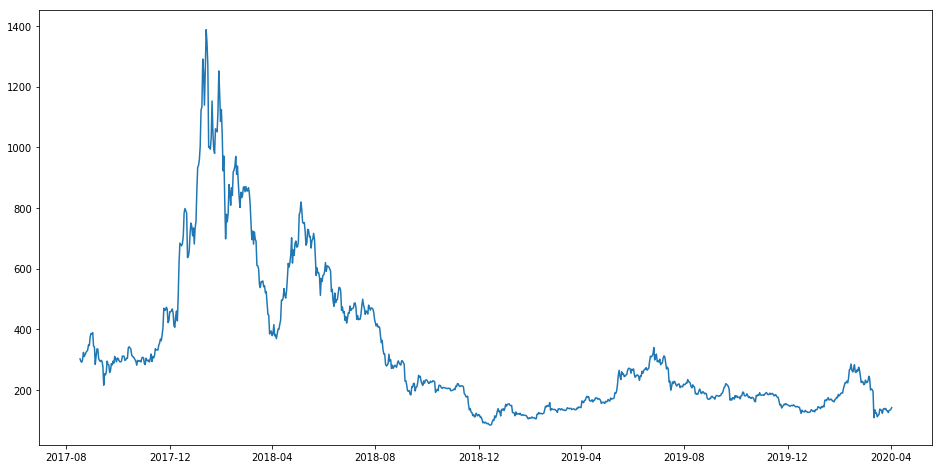

In [22]:
#Let's visualize some data
plt.figure(figsize=(16,8))
plt.plot(data.close_time,data.c)
plt.savefig('images/foo.png', bbox_inches='tight')

## Define main functions

In [23]:
def tester(test_ser, take_prof, stop_loss, tplong, tpshort, verb = 1, strategy = '', time_period = 30, close_nxt_day = False):
    signal = 0
    call = 'flat'
    order_amount = 10
    num = 0
    long_paid = 0
    long_profit = 0
    short_paid = 0
    short_profit = 0
    order_book = pd.DataFrame(columns = ['time', 'price', 'paid', 'size', 'order', 'type',
                                         'close_time', 'close_price','profit', 'perc', 'TP', 'SL'])
    ti = time.time()
    test_ser.reset_index(drop=True, inplace = True)
    #test_ser = test_ser.loc[-time_period:, :].copy()
    test_ser = test_ser.tail(time_period).copy()
    test_ser.reset_index(drop=True, inplace = True)
    for c in range(test_ser.shape[0]):

        if test_ser[strategy].loc[c] == 1:
            signal = 1
            call = 'long'
            price_d = 1.001
        elif test_ser[strategy].loc[c] == -1:
            signal = -1
            call = 'short'
            price_d = 0.999
        elif test_ser[strategy].loc[c] == 0:
            signal = 0
            call = 'flat'
        else:
            signal = 2
            call = 'flat'
            
        # Create Order
        if call != 'flat':
            price = price_d * test_ser.c[c]
            paid = order_amount
            coins = paid/price
            paid = paid*1.0025
            if call == 'long':
                long_paid += paid
                sl = stop_loss * price
            else:
                short_paid += paid
                sl = (2 - stop_loss) * price
            order_book.loc[num] = [test_ser.close_time[c], price, paid, coins, call, 'open', 
                                   test_ser.close_time[c], price, 0, 0, take_prof, sl]
            num += 1
        
        # Stop Loss, Take Profit, Time Stop
        for index, row in order_book[order_book['type'] == 'open'].iterrows():
            if row['order'] == 'long' and (tplong(signal) or c == test_ser.shape[0] - 1) or (close_nxt_day and test_ser.close_time[c] != row['time']):
                # Close Order
                order_book.loc[index,:], long_profit = take_long_prof(row, 
                                                                      test_ser.c[c], 
                                                                      test_ser.close_time[c], 
                                                                      long_profit)
            
            if row['order'] == 'short' and (tpshort(signal) or c == test_ser.shape[0] - 1) or (close_nxt_day and test_ser.close_time[c] != row['time']):
                # Close Order
                order_book.loc[index,:], short_profit = take_short_prof(row, 
                                                                        test_ser.c[c], 
                                                                        test_ser.close_time[c], 
                                                                        short_profit)
        if (c+1)%200==0 and verb == 1:
            ord_book = order_book.copy(deep = True)
            ord_book.to_csv(r'orders_not.csv')
            print('Perc_long = ' + '{0:.2f}'.format(100*long_profit / (long_paid+0.0001)) + '%' )
            print("Perc_short = " + "{0:.2f}".format(100*short_profit / (short_paid+ 0.0001)) + '%' )
            progress_display(c + 1, len(test_ser.close_time), ti)
            print('-----------------------------------')
    if verb == 1:
        print('Paid for long', long_paid)
        print('Profit from long', long_profit)
        print('Perc_long = ' + '{0:.2f}'.format(100*long_profit / (long_paid+0.0001)) + '%' )
        print('Paid for short', short_paid)
        print('Profit from short', short_profit)
        print("Perc_short = " + "{0:.2f}".format(100*short_profit / (short_paid+0.0001)) + '%' )
    ord_book = order_book.copy(deep = True)
    for z in range(len(order_book.time)):
        ord_book.loc[z,'time'] = ord_book.loc[z,'time'].strftime("%Y-%m-%d %H:%M:%S")
        ord_book.loc[z,'close_time'] = ord_book.loc[z,'close_time'].strftime("%Y-%m-%d %H:%M:%S")
    ord_book['perc'] = ord_book['perc'] * 100
        
    return ord_book, [long_paid, long_profit, short_paid, short_profit]

In [24]:
def tester_help(test_ser, take_prof, stop_loss, tplong, tpshort, verb = 1, strategy = '', time_period = 30, close_nxt_day = False):
    zz = 0
    zz_olong = 0
    zz_oshort = 0
    minn = 10000
    for i in range(30,time_period+30,30):
        orders, ord_res = tester(test_ser.tail(time_period).head(i), take_prof, stop_loss, tplong, tpshort,
                                 verb = verb, strategy = strategy, close_nxt_day = close_nxt_day, time_period = 30)
        z0 = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
        zz += z0
        if z0 < minn:
            minn = z0
        zz_olong += orders[(orders['order']=='long')&(orders['profit']>0)].shape[0]/(orders[orders['order']=='long'].shape[0]+0.0001)
        zz_oshort += orders[(orders['order']=='short')&(orders['profit']>0)].shape[0]/(orders[orders['order']=='short'].shape[0]+0.0001)
    return zz/(time_period/30), zz_olong/(time_period/30), zz_oshort/(time_period/30), minn
        
        

In [25]:
def take_long_prof(row, pr, time, longg_profit):
    row = row.copy()
    row['close_time'] = time
    row.loc['type'] = 'close'
    price = 0.999*pr
    row.loc['profit'] = row.loc['size']*price*0.999 - row.loc['paid']
    row.loc['perc'] = row.loc['profit'] / row.loc['paid']
    longg_profit += row.loc['profit']
    row.loc['close_price'] = price
    return row, longg_profit
    
def take_short_prof(row, pr, time, shortt_profit):
    row = row.copy()
    row['close_time'] = time
    row['type'] = 'close'
    price = 1.001*pr
    row['profit'] = row['paid'] - row['size']*price*0.999
    row['perc'] = row.loc['profit'] / row.loc['paid']
    shortt_profit += row['profit']
    row['close_price'] = price
    return row, shortt_profit

In [26]:
def plot_orders(orders, test_ser, signal):
    orders.time = pd.to_datetime(orders.time)
    orders.close_time = pd.to_datetime(orders.close_time)
    test_ser.close_time = pd.to_datetime(test_ser.close_time)
    test_ser.set_index('close_time', inplace=True)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(test_ser['c'])
    color = '-vr'
    if signal == 'long':
        color = '-^g'
    for index, row in orders[orders['order'] == signal].iterrows():
        #print(row)
        x1 = row.loc['time']
        x2 = row.loc['close_time']
        y1 = test_ser.loc[x1, 'c']
        y2 = test_ser.loc[x2, 'c']
        #print(x1, x2, y1, y2)
        ax.plot([x1,x2], [y1, y2], color, linewidth=.5)
    return fig, ax

In [27]:
def progress_display(a, b, ti):
    percc = 100 * a / b
    print("Progress: " + "{0:.2f}".format(percc) + '%')
    ttt = time.time() - ti
    time_now = chop_microseconds(datetime.timedelta(seconds = ttt))
    print("Time: " + str(time_now))
    time_left = chop_microseconds(datetime.timedelta(seconds = (100 * (ttt / percc)) - ttt))
    print("Left time: " + str(time_left))

In [28]:
def chop_microseconds(delta):
    return delta - datetime.timedelta(microseconds=delta.microseconds)

<a id='ma'></a>

## 1. [Moving Averages](#start)

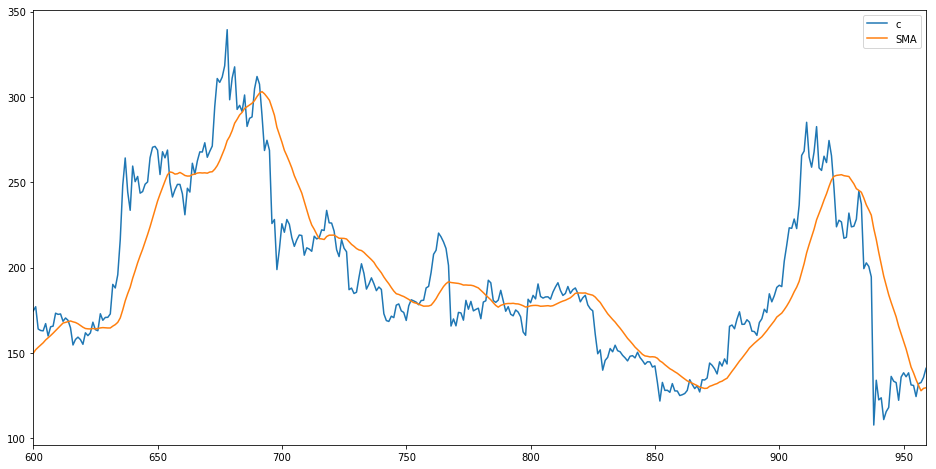

In [29]:
# MA
data['SMA'] = ta.SMA(data.c, timeperiod = 20)
data[['c','SMA']].tail(360).plot(figsize=(16,8))

In [30]:
# Create strategy
#data['SMA_startegy'] = np.where(data['SMA'] < data['c'], 1, -1)
data['SMA_startegy'] = 0
data['SMA_startegy'] = np.where((data['SMA'] > data['c']) & (data['SMA'].shift() < data['c'].shift()), -1, data['SMA_startegy'])
data['SMA_startegy'] = np.where((data['SMA'] < data['c']) & (data['SMA'].shift() > data['c'].shift()), 1, data['SMA_startegy'])
#data['SMA_startegy'] = np.where((data['SMA'] > data['c']), -1, data['SMA_startegy'])
#data['SMA_startegy'] = np.where((data['SMA'] < data['c']), 1, data['SMA_startegy'])

t_period = 30
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'SMA_startegy', 
                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

Paid for long 10.024999999999999
Profit from long 0.6214867118342831
Perc_long = 6.20%
Paid for short 0
Profit from short 0
Perc_short = 0.00%


In [31]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-03-30 00:00:00,132.19206,10.025,0.075648,long,close,2020-04-02 00:00:00,140.87898,0.621487,6.19937,0,0.0


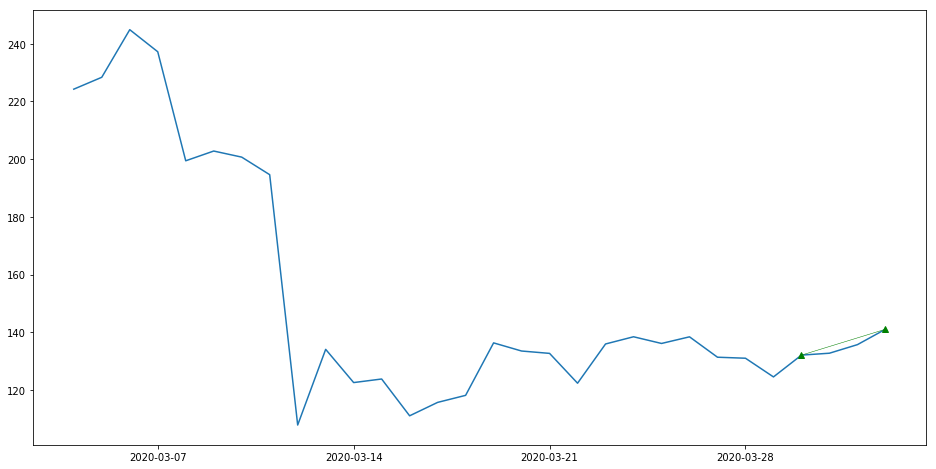

In [33]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [23]:
def tuning_sma_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(2,80))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'orders_long', 'orders_short', 'alpha', 'min'])
    dd = 0
    for i in range(2,80):
        for j in [0, 1]:
            # Create strategy
            data['SMA'] = ta.SMA(data.c, timeperiod = i)
            data['SMA_startegy'] = 0
            if j == 0:
                data['SMA_startegy'] = np.where((data['SMA'] > data['c']) & (data['SMA'].shift() < data['c'].shift()), -1, data['SMA_startegy'])
                data['SMA_startegy'] = np.where((data['SMA'] < data['c']) & (data['SMA'].shift() > data['c'].shift()), 1, data['SMA_startegy'])
            else:
                data['SMA_startegy'] = np.where((data['SMA'] > data['c']), -1, data['SMA_startegy'])
                data['SMA_startegy'] = np.where((data['SMA'] < data['c']), 1, data['SMA_startegy'])
            # Test strategy
            #orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'SMA_startegy',
            #                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)
            
            s, olong, oshort, minn = tester_help(data, 0, 0, verb = 0, strategy = 'SMA_startegy',
                                     time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)
            
            #s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
            #olong = orders[orders['order']=='long'].shape[0]
            #oshort = orders[orders['order']=='short'].shape[0]
            if s > 0:
                df_params.loc[dd,:] = [s, i, j, olong, oshort, s*(olong+oshort)/2, minn]
                dd +=1
        if (t-1)%10 == 0:
            progress_display(t, ll, ti)
            df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [24]:
df_params_sma = tuning_sma_strategy(data, t_period = 360)

Progress: 1.28%
Time: 0:00:06
Left time: 0:08:41
Progress: 14.10%
Time: 0:01:02
Left time: 0:06:18
Progress: 26.92%
Time: 0:01:53
Left time: 0:05:08
Progress: 39.74%
Time: 0:02:45
Left time: 0:04:10
Progress: 52.56%
Time: 0:03:36
Left time: 0:03:15
Progress: 65.38%
Time: 0:04:27
Left time: 0:02:21
Progress: 78.21%
Time: 0:05:18
Left time: 0:01:28
Progress: 91.03%
Time: 0:06:07
Left time: 0:00:36


In [26]:
df_params_sma2 = df_params_sma.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_sma2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_sma2.to_csv(r'sma_strat_tuning.csv')
df_params_sma3 = df_params_sma2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_sma3[(df_params_sma3['orders_long']+5>df_params_sma3['orders_short'])&
              (df_params_sma3['orders_long']-5<df_params_sma3['orders_short'])&
              (df_params_sma3['orders_long']>5)&(df_params_sma3['orders_short']>5)].head(10)
df_params_sma3.head(10)

,maxx,i,j,orders_long,orders_short,alpha,min
19,6.93701,14,0,0.423574,0.381918,2.79385,-1.2357
17,6.66139,13,0,0.388858,0.36803,2.52096,-1.98123
15,6.49662,12,0,0.402746,0.333316,2.39096,-1.87055
35,5.79454,22,0,0.374965,0.430518,2.3337,-5.29993
21,6.166,15,0,0.388858,0.347202,2.26927,-3.7304
49,6.34174,29,0,0.374965,0.319416,2.20179,-5.20798
23,5.83197,16,0,0.395802,0.340258,2.14634,-3.7304
7,5.11587,8,0,0.368034,0.451366,2.09597,-1.51523
47,6.03444,28,0,0.374965,0.319421,2.09511,-5.20798
37,5.33698,23,0,0.374965,0.402741,2.0753,-6.56308


<a id='bb'></a>

## 2. [Bollinger Bands](#start)

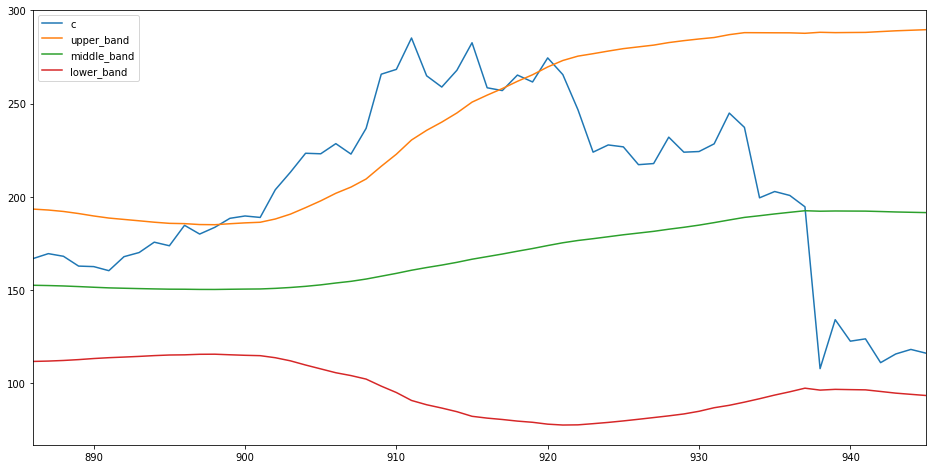

In [91]:
# Bollinger Bands
data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data.c, timeperiod = 79, nbdevup=2, nbdevdn=2)
# Plot
data[['c','upper_band','middle_band','lower_band']].tail(60).plot(figsize=(16,8))
plt.show()

In [95]:
# Create strategy
data['BB_startegy'] = 0
#data['BB_startegy'] = np.where((data['upper_band'] <= data['c']) & (data['upper_band'].shift() > data['c'].shift()),
#                               -1, 
#                               data['BB_startegy'])
#data['BB_startegy'] = np.where((data['lower_band'] >= data['c']) & (data['lower_band'].shift() < data['c'].shift()),
#                               1, 
#                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['upper_band'] > data['c']) & (data['upper_band'].shift() < data['c'].shift()),
                               -1, 
                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['lower_band'] < data['c']) & (data['lower_band'].shift() > data['c'].shift()),
                               1, 
                               data['BB_startegy'])
'''
data['BB_startegy'] = np.where((data['upper_band'] < data['c']) & (data['upper_band'].shift() > data['c'].shift()),
                               1, 
                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['lower_band'] > data['c']) & (data['lower_band'].shift() < data['c'].shift()),
                               -1, 
                               data['BB_startegy'])
'''
bb_dif = (data['upper_band'] - data['middle_band']) * 0.8
data['BB_startegy'] = np.where((data['middle_band']+bb_dif < data['c']) & (data['middle_band'].shift()+bb_dif > data['c'].shift()),
                               2, 
                               data['BB_startegy'])
data['BB_startegy'] = np.where((data['middle_band']-bb_dif > data['c']) & (data['middle_band'].shift()-bb_dif < data['c'].shift()),
                               2, 
                               data['BB_startegy'])
t_period = 60
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'BB_startegy', 
                         time_period = t_period, 
                         tplong = lambda x: x == 2 or x == -1, 
                         tpshort = lambda x: x == 2 or x == 1)

Paid for long 0
Profit from long 0
Perc_long = 0.00%
Paid for short 30.074999999999996
Profit from short 17.68389406137267
Perc_short = 58.80%


In [96]:
orders.tail()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-02-20 00:00:00,256.70304,10.025,0.038956,short,close,2020-03-12 00:00:00,107.92782,5.82482,58.1029,0,513.40608
1,2020-02-22 00:00:00,261.30843,10.025,0.038269,short,close,2020-03-12 00:00:00,107.92782,5.89885,58.8414,0,522.61686
2,2020-02-24 00:00:00,265.25448,10.025,0.037700,short,close,2020-03-12 00:00:00,107.92782,5.96023,59.4536,0,530.50896


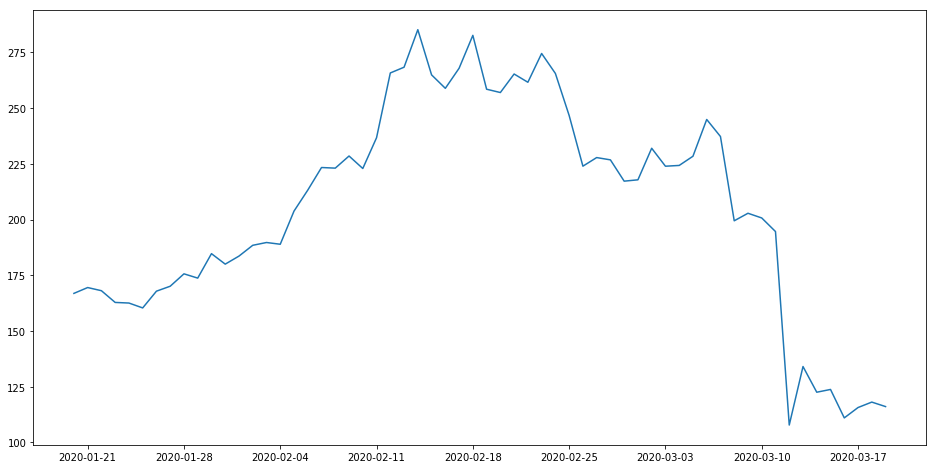

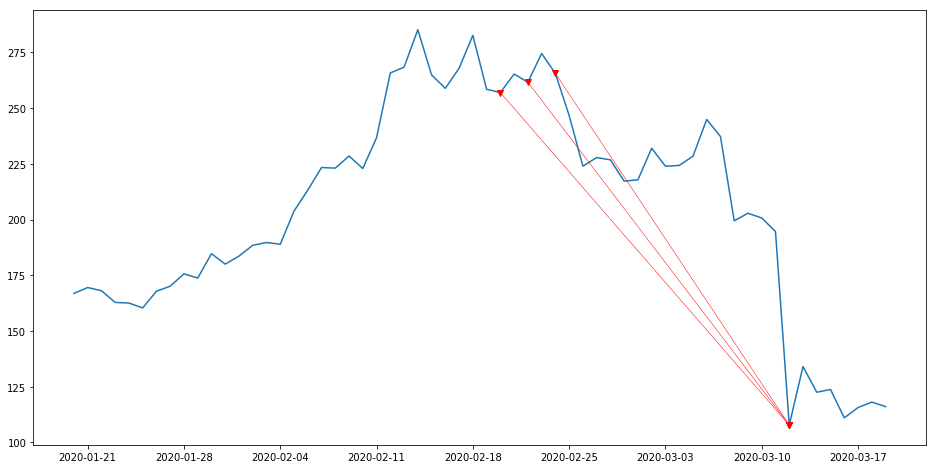

In [97]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

In [83]:
def tuning_bb_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(2,80))#*len(np.arange(0.1,1.0,0.1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'z', 'orders_long', 'orders_short', 'alpha', 'min'])
    dd = 0
    for i in range(2,80):
        for j in np.arange(0.1,1.0,0.1):
            for z in range(0,1):
                # Create strategy
                data['upper_band'], data['middle_band'], data['lower_band'] = ta.BBANDS(data.c, timeperiod = i)
                data['BB_startegy'] = 0

                data['BB_startegy'] = np.where((data['upper_band'] > data['c']) & (data['upper_band'].shift() < data['c'].shift()),
                                                -1, 
                                                data['BB_startegy'])
                data['BB_startegy'] = np.where((data['lower_band'] < data['c']) & (data['lower_band'].shift() > data['c'].shift()),
                                                1, 
                                                data['BB_startegy'])
                if z == 1:
                    data['BB_startegy'] = np.where((data['upper_band'] < data['c']) & (data['upper_band'].shift() > data['c'].shift()),
                                                    1, 
                                                    data['BB_startegy'])
                    data['BB_startegy'] = np.where((data['lower_band'] > data['c']) & (data['lower_band'].shift() < data['c'].shift()),
                                                    -1, 
                                                    data['BB_startegy'])

                bb_dif = (data['upper_band'] - data['middle_band']) * j
                data['BB_startegy'] = np.where((data['middle_band']+bb_dif < data['c']) & (data['middle_band'].shift()+bb_dif > data['c'].shift()),
                                               2, 
                                               data['BB_startegy'])
                data['BB_startegy'] = np.where((data['middle_band']-bb_dif > data['c']) & (data['middle_band'].shift()-bb_dif < data['c'].shift()),
                                               2, 
                                               data['BB_startegy'])
                # Test strategy
                s, olong, oshort, minn = tester_help(data, 0, 0, verb = 0, strategy = 'BB_startegy', 
                                         time_period = t_period, 
                                         tplong = lambda x: x == 2 or x == -1, 
                                         tpshort = lambda x: x == 2 or x == 1)

                #s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                #olong = orders[orders['order']=='long'].shape[0]
                #oshort = orders[orders['order']=='short'].shape[0]
                if s > 0:
                    df_params.loc[dd,:] = [s, i, j, z, olong, oshort, s*(olong+oshort)/2, minn]
                    dd +=1
        if (t-1)%10 == 0:
            progress_display(t, ll, ti)
            df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [87]:
df_params_bb = tuning_bb_strategy(data, t_period = 90)

Progress: 1.28%
Time: 0:00:00
Left time: 0:00:53
Progress: 14.10%
Time: 0:00:14
Left time: 0:01:31
Progress: 26.92%
Time: 0:00:30
Left time: 0:01:22
Progress: 39.74%
Time: 0:00:44
Left time: 0:01:07
Progress: 52.56%
Time: 0:00:57
Left time: 0:00:51
Progress: 65.38%
Time: 0:01:12
Left time: 0:00:38
Progress: 78.21%
Time: 0:01:28
Left time: 0:00:24
Progress: 91.03%
Time: 0:01:40
Left time: 0:00:09


In [90]:
df_params_bb2 = df_params_bb.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_bb2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_bb2.to_csv(r'bb_strat_tuning.csv')
df_params_bb3 = df_params_bb2.sort_values(axis = 0, by = ['alpha','min'], ascending=False)
df_params_bb3[(df_params_bb3['orders_long']+5>df_params_bb3['orders_short'])&
              (df_params_bb3['orders_long']-5<df_params_bb3['orders_short'])&
              (df_params_bb3['orders_long']>5)&(df_params_bb3['orders_short']>5)].head(10)
df_params_bb3.head(10)

,maxx,i,j,z,orders_long,orders_short,alpha,min
78,8.71331,50,0.9,0,0.333333,2,10.1655,-2.75817
88,8.42029,52,0.9,0,0.333333,2,9.82367,-2.86581
178,14.0628,79,0.8,0,0.333333,1,9.37522,0
73,8.78626,49,0.9,0,0.333333,1.66667,8.78626,-2.53932
91,7.98079,53,0.9,0,0.333333,1.66667,7.98079,-4.18429
47,9.00263,42,0.9,0,0.333333,1.33333,7.50219,-1.96503
172,11.1503,79,0.2,0,0.333333,1,7.43355,0
173,11.0525,79,0.3,0,0.333333,1,7.3683,0
60,8.75191,46,0.9,0,0.333333,1.33333,7.29326,-2.71718
64,8.74565,47,0.9,0,0.333333,1.33333,7.28804,-2.66114


<a id='macd'></a>

## 3. [MACD Strategy](#start)

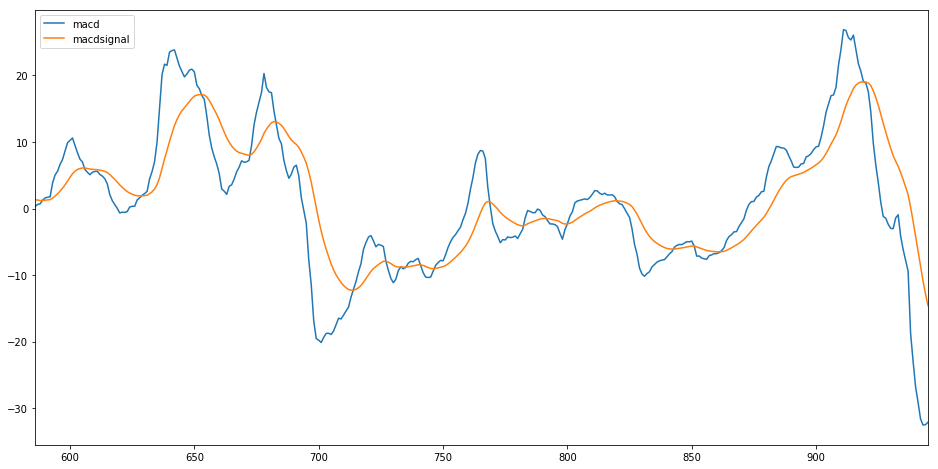

In [57]:
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.c, fastperiod=10, slowperiod=22, signalperiod=21)
data[['macd','macdsignal']].tail(360).plot(figsize=(16,8))

In [58]:
# Create strategy
data['MACD_startegy'] = 0
#data['MACD_startegy'] = np.where((data['SMA'] > data['c']) & (data['SMA'].shift() < data['c'].shift()), -1, data['MACD_startegy'])
#data['MACD_startegy'] = np.where((data['SMA'] < data['c']) & (data['SMA'].shift() > data['c'].shift()), 1, data['MACD_startegy'])
data['MACD_startegy'] = np.where((data['macd'] > data['macdsignal']), 1, data['MACD_startegy'])
data['MACD_startegy'] = np.where((data['macd'] < data['macdsignal']), -1, data['MACD_startegy'])

t_period = 60
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'MACD_startegy', 
                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

Paid for long 340.8499999999999
Profit from long 110.29413674893638
Perc_long = 32.36%
Paid for short 260.6500000000001
Profit from short 89.10343574664672
Perc_short = 34.19%


In [59]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-01-20 00:00:00,167.03687,10.025,0.059867,long,close,2020-02-23 00:00:00,274.20552,6.37445,63.5856,0,0.0
1,2020-01-21 00:00:00,169.65949,10.025,0.058942,long,close,2020-02-23 00:00:00,274.20552,6.12095,61.0568,0,0.0
2,2020-01-22 00:00:00,168.23807,10.025,0.059440,long,close,2020-02-23 00:00:00,274.20552,6.25736,62.4176,0,0.0
3,2020-01-23 00:00:00,162.97281,10.025,0.061360,long,close,2020-02-23 00:00:00,274.20552,6.78341,67.6649,0,0.0
4,2020-01-24 00:00:00,162.70254,10.025,0.061462,long,close,2020-02-23 00:00:00,274.20552,6.81133,67.9434,0,0.0


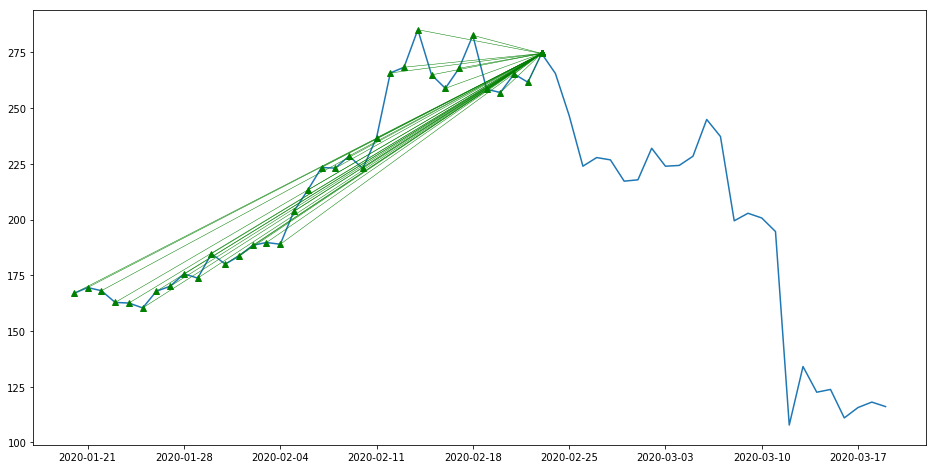

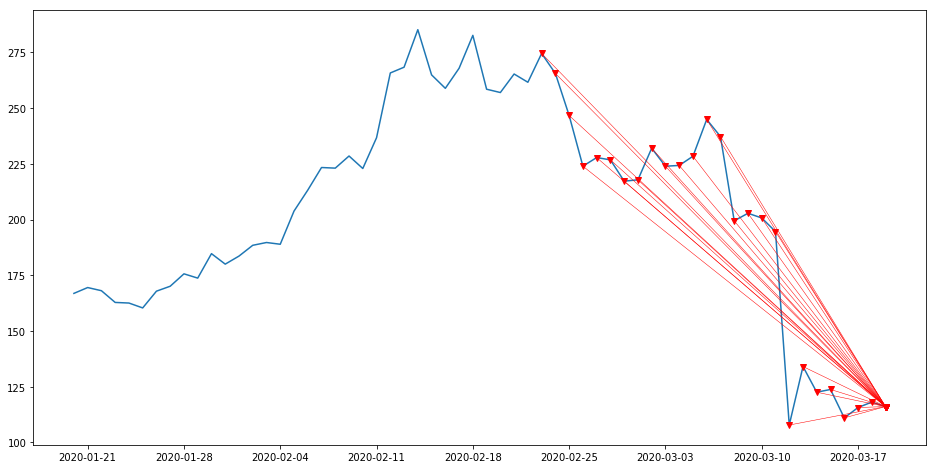

In [60]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [54]:
def tuning_macd_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(2,40,2))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'q', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in range(2,40,2):
        for j in range(i,50,2):
            for q in range(i,j,1):
                # Create strategy
                data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.c, fastperiod=i, slowperiod=j, signalperiod=q)
                # Create strategy
                data['MACD_startegy'] = 0
                data['MACD_startegy'] = np.where((data['macd'] > data['macdsignal']), 1, data['MACD_startegy'])
                data['MACD_startegy'] = np.where((data['macd'] < data['macdsignal']), -1, data['MACD_startegy'])
                # Test strategy
                orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'MACD_startegy', 
                                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

                s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                olong = orders[orders['order']=='long'].shape[0]
                oshort = orders[orders['order']=='short'].shape[0]
                if s > 0:
                    df_params.loc[dd,:] = [s, i, j, q, olong, oshort, s*(olong+oshort)/2]
                    dd +=1
        #if (t-1)%10 == 0:
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [55]:
df_params_macd = tuning_macd_strategy(data, t_period = 60)

Progress: 4.17%
Time: 0:22:09
Left time: 8:29:35
Progress: 8.33%
Time: 0:41:34
Left time: 7:37:15
Progress: 12.50%
Time: 1:02:08
Left time: 7:15:00
Progress: 16.67%
Time: 1:07:57
Left time: 5:39:46
Progress: 20.83%
Time: 1:12:40
Left time: 4:36:10
Progress: 25.00%
Time: 1:16:58
Left time: 3:50:54
Progress: 29.17%
Time: 1:20:50
Left time: 3:16:18
Progress: 33.33%
Time: 1:24:18
Left time: 2:48:37
Progress: 37.50%
Time: 1:27:21
Left time: 2:25:36
Progress: 41.67%
Time: 1:30:05
Left time: 2:06:07
Progress: 45.83%
Time: 1:32:26
Left time: 1:49:15
Progress: 50.00%
Time: 1:34:25
Left time: 1:34:25
Progress: 54.17%
Time: 1:36:05
Left time: 1:21:18
Progress: 58.33%
Time: 1:37:29
Left time: 1:09:38
Progress: 62.50%
Time: 1:38:38
Left time: 0:59:11
Progress: 66.67%
Time: 1:39:33
Left time: 0:49:46
Progress: 70.83%
Time: 1:40:17
Left time: 0:41:17
Progress: 75.00%
Time: 1:40:50
Left time: 0:33:36
Progress: 79.17%
Time: 1:41:14
Left time: 0:26:38


In [71]:
df_params_macd2 = df_params_macd.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_macd2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_macd2.to_csv(r'macd_strat_tuning.csv')
df_params_macd3 = df_params_macd2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_macd3[(df_params_macd3['orders_long']+5>df_params_macd3['orders_short'])&
              (df_params_macd3['orders_long']-5<df_params_macd3['orders_short'])&
              (df_params_macd3['orders_long']>5)&(df_params_macd3['orders_short']>5)].head(10)
df_params_macd3.head(10)

,maxx,i,j,q,orders_long,orders_short,alpha
1971,33.2718,10,22,21,34,26,998.155
694,32.6975,4,28,24,32,28,980.926
696,30.9614,4,28,26,33,27,928.843
261,30.1851,2,34,33,35,25,905.554
229,28.9086,2,32,31,34,26,867.258
227,27.5734,2,32,29,33,27,827.203
226,27.3214,2,32,28,32,28,819.642
673,26.3687,4,26,25,31,29,791.062
144,26.0858,2,26,23,28,32,782.575
1965,25.9339,10,22,15,31,29,778.018


<a id='rsi'></a>

## 4. [RSI Strategy](#start)

c:\python\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


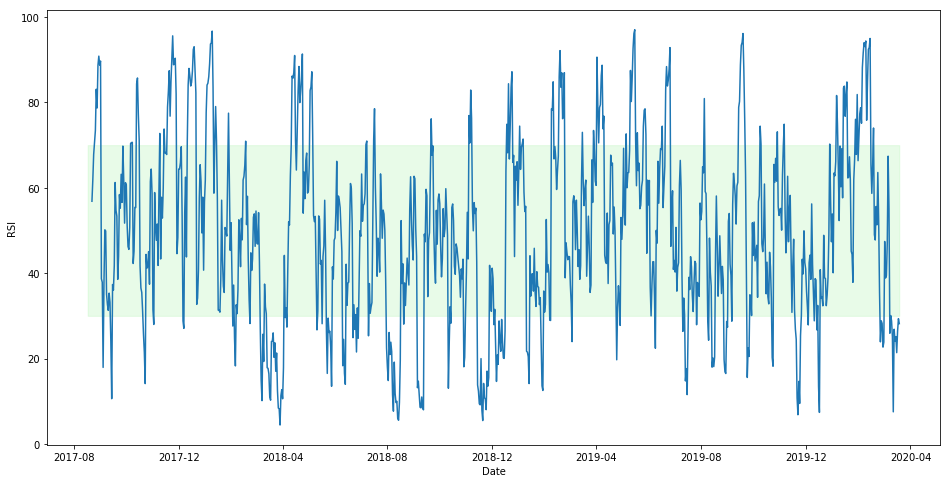

In [10]:
# RSI
data['RSI'] = ta.RSI(data.c, timeperiod=5)
# Plotting RSI
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(data.close_time, data.RSI, label='RSI')
ax.fill_between(data.close_time, y1=30, y2=70, color = 'lightgreen', alpha='0.2')
ax.set_xlabel('Date')
ax.set_ylabel('RSI')
plt.show()

In [17]:
# Create strategy
data['RSI_startegy'] = 0
data['RSI_startegy'] = np.where((data['RSI'] > 100-32) & (data['RSI'].shift() < 100-32), 1, data['RSI_startegy'])
data['RSI_startegy'] = np.where((data['RSI'] < 32) & (data['RSI'].shift() > 32), -1, data['RSI_startegy'])
data['RSI_startegy'] = np.where((data['RSI'] > 32+16) & (data['RSI'] < 100-32-16), 2, data['RSI_startegy'])

t_period = 500
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'RSI_startegy', 
                         time_period = t_period, tplong = lambda x: x == 2, tpshort = lambda x: x == 2)

Perc_long = 5.74%
Perc_short = -11.82%
Progress: 40.00%
Time: 0:00:01
Left time: 0:00:02
-----------------------------------
Perc_long = 6.28%
Perc_short = -4.13%
Progress: 80.00%
Time: 0:00:03
Left time: 0:00:00
-----------------------------------
Paid for long 310.775
Profit from long 63.374977226849225
Perc_long = 20.39%
Paid for short 310.775
Profit from short 0.7593634299371548
Perc_short = 0.24%


In [18]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2018-11-14 00:00:00,187.24257,10.025,0.053407,short,close,2019-03-10 00:00:00,135.50537,2.79535,27.8838,0,374.48514
1,2018-11-30 00:00:00,113.61627,10.025,0.088016,short,close,2019-03-10 00:00:00,135.50537,-1.88965,-18.8494,0,227.23254
2,2018-12-03 00:00:00,108.65124,10.025,0.092038,short,close,2019-03-10 00:00:00,135.50537,-2.43412,-24.2805,0,217.30248
3,2018-12-18 00:00:00,100.49039,10.025,0.099512,long,close,2019-03-10 00:00:00,135.23463,3.41901,34.1049,0,0.00000
4,2018-12-22 00:00:00,115.31520,10.025,0.086719,long,close,2019-03-10 00:00:00,135.23463,1.69066,16.8645,0,0.00000


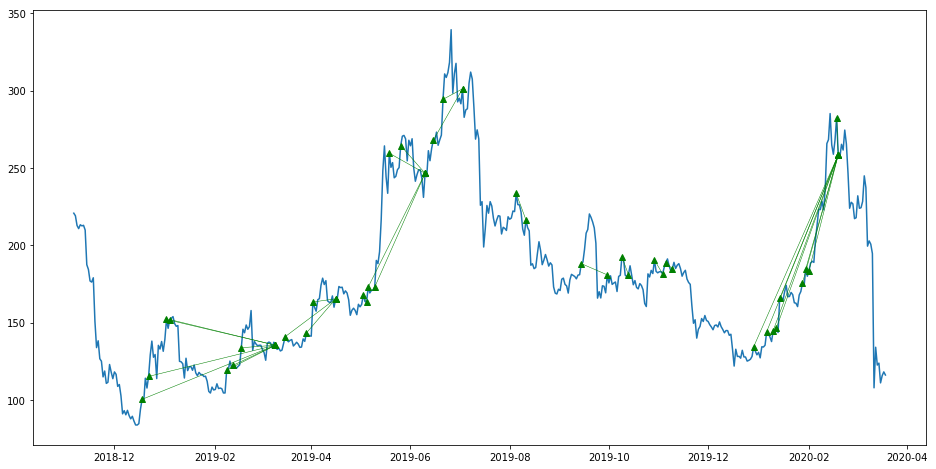

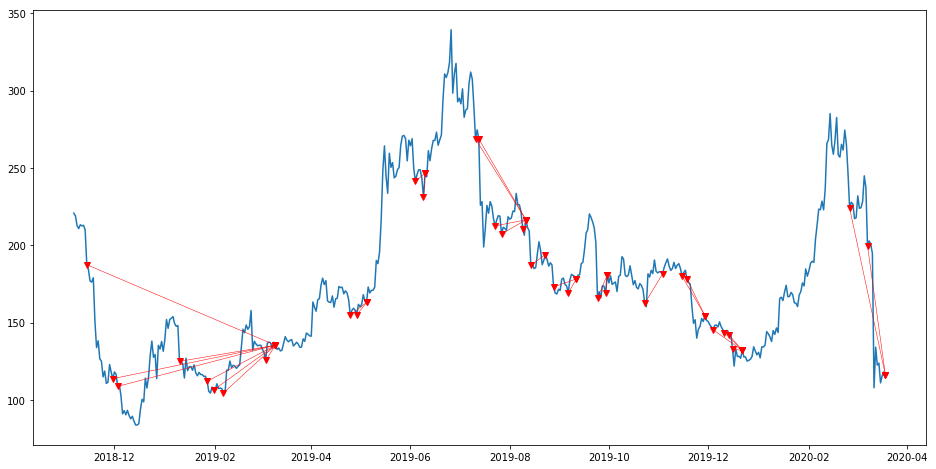

In [19]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [67]:
def tuning_rsi_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(2,30,1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'q', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in range(2,30,1):
        for j in range(20,40,2):
            for q in range(1,20,1):
                data['RSI'] = ta.RSI(data.c, timeperiod=i)
                # Create strategy
                data['RSI_startegy'] = 0
                data['RSI_startegy'] = np.where((data['RSI'] > 100-j) & (data['RSI'].shift() < 100-j), 1, data['RSI_startegy'])
                data['RSI_startegy'] = np.where((data['RSI'] < j) & (data['RSI'].shift() > j), -1, data['RSI_startegy'])
                data['RSI_startegy'] = np.where((data['RSI'] > j+q) & (data['RSI'] < 100-j-q), 2, data['RSI_startegy'])
                # Test strategy
                orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'RSI_startegy', 
                                         time_period = t_period, tplong = lambda x: x == 2, tpshort = lambda x: x == 2)

                s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                olong = orders[orders['order']=='long'].shape[0]
                oshort = orders[orders['order']=='short'].shape[0]
                if s > 0:
                    df_params.loc[dd,:] = [s, i, j, q, olong, oshort, s*(olong+oshort)/2]
                    dd +=1
        if (t-1)%2 == 0:
            progress_display(t, ll, ti)
            df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [68]:
df_params_rsi = tuning_rsi_strategy(data, t_period = 90)

Progress: 1.28%
Time: 0:01:09
Left time: 1:28:47
Progress: 3.85%
Time: 0:02:44
Left time: 1:08:31
Progress: 6.41%
Time: 0:03:55
Left time: 0:57:19
Progress: 8.97%
Time: 0:04:56
Left time: 0:50:10
Progress: 11.54%
Time: 0:05:51
Left time: 0:44:56
Progress: 14.10%
Time: 0:06:46
Left time: 0:41:13
Progress: 16.67%
Time: 0:07:36
Left time: 0:38:04
Progress: 19.23%
Time: 0:08:25
Left time: 0:35:22
Progress: 21.79%
Time: 0:09:12
Left time: 0:33:03
Progress: 24.36%
Time: 0:09:56
Left time: 0:30:52
Progress: 26.92%
Time: 0:10:39
Left time: 0:28:54
Progress: 29.49%
Time: 0:11:19
Left time: 0:27:04
Progress: 32.05%
Time: 0:11:59
Left time: 0:25:24
Progress: 34.62%
Time: 0:12:36
Left time: 0:23:49


In [72]:
df_params_rsi2 = df_params_rsi.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_rsi2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_rsi2.to_csv(r'rsi_strat_tuning.csv')
df_params_rsi3 = df_params_rsi2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_rsi3[(df_params_rsi3['orders_long']+5>df_params_rsi3['orders_short'])&
              (df_params_rsi3['orders_long']-5<df_params_rsi3['orders_short'])&
              (df_params_rsi3['orders_long']>5)&(df_params_rsi3['orders_short']>5)].head(10)
df_params_rsi3.head(10)

,maxx,i,j,q,orders_long,orders_short,alpha
584,49.9758,5,32,16,9,2,274.867
614,39.6079,5,36,12,9,3,237.648
567,46.4314,5,30,18,7,3,232.157
602,34.7826,5,34,15,9,4,226.087
601,34.3915,5,34,14,9,4,223.545
734,31.1827,6,32,15,9,3,187.096
735,31.0173,6,32,16,9,3,186.104
717,32.69,6,30,17,6,4,163.45
718,32.4419,6,30,18,6,4,162.209
582,27.1159,5,32,14,9,2,149.138


<a id='obv'></a>

## 5. [OBV Strategy](#start)

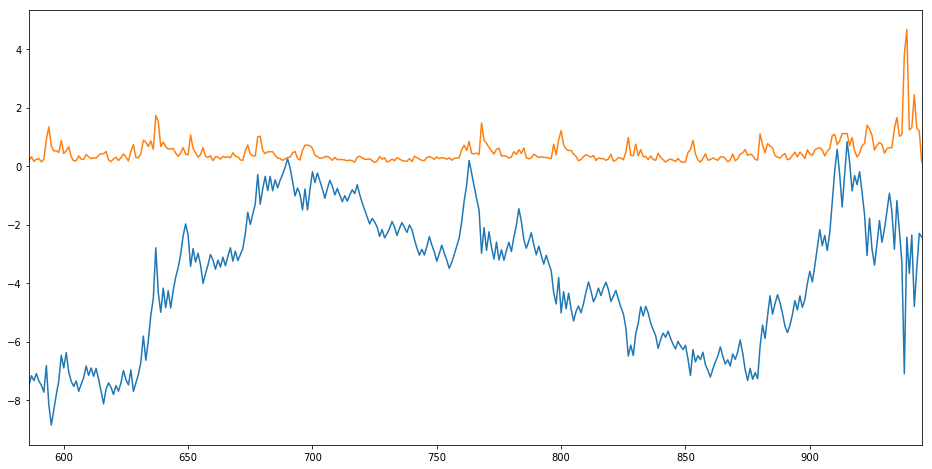

In [73]:
# OBV
data['OBV'] = ta.OBV(data.c, data.v)
(data['OBV']/10**6).tail(360).plot(figsize=(16,8))
(data['v']/10**6).tail(360).plot(figsize=(16,8))

In [74]:
# Create strategy
data['OBV_startegy'] = 0
#data['OBV_startegy'] = np.where((data['OBV'] > data['OBV'].shift()) & (data['c'] > data['c'].shift()), 1, data['OBV_startegy'])
#data['OBV_startegy'] = np.where((data['OBV'] < data['OBV'].shift()) & (data['c'] < data['c'].shift()), -1, data['OBV_startegy'])

data['OBV_startegy'] = np.where((data['OBV'] > data['OBV'].shift()) & 
                                (data['c']/data['c'].shift() > data['c'].shift()/data['c'].shift(2)), 1, data['OBV_startegy'])
data['OBV_startegy'] = np.where((data['OBV'] > data['OBV'].shift()) & 
                                (data['c']/data['c'].shift() < data['c'].shift()/data['c'].shift(2)), -1, data['OBV_startegy'])
data['OBV_startegy'] = np.where((data['OBV'] < data['OBV'].shift()) & 
                                (data['c']/data['c'].shift() > data['c'].shift()/data['c'].shift(2)), 1, data['OBV_startegy'])
data['OBV_startegy'] = np.where((data['OBV'] < data['OBV'].shift()) & 
                                (data['c']/data['c'].shift() < data['c'].shift()/data['c'].shift(2)), -1, data['OBV_startegy'])
t_period = 60
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'OBV_startegy', 
                         time_period = t_period, tplong = lambda x: x == -1 or x == 0, tpshort = lambda x: x == 1 or x == 0)

Paid for long 300.75
Profit from long -3.447002762923617
Perc_long = -1.15%
Paid for short 300.75
Profit from short 2.761590571713657
Perc_short = 0.92%


In [75]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-01-20 00:00:00,167.03687,10.025,0.059867,long,close,2020-01-22 00:00:00,167.90193,0.0167368,0.16695,0,0.00000
1,2020-01-21 00:00:00,169.65949,10.025,0.058942,long,close,2020-01-22 00:00:00,167.90193,-0.13849,-1.38144,0,0.00000
2,2020-01-22 00:00:00,167.90193,10.025,0.059559,short,close,2020-01-24 00:00:00,162.70254,0.344359,3.435,0,335.80386
3,2020-01-23 00:00:00,162.64719,10.025,0.061483,short,close,2020-01-24 00:00:00,162.70254,0.0316003,0.315215,0,325.29438
4,2020-01-24 00:00:00,162.70254,10.025,0.061462,long,close,2020-01-25 00:00:00,160.18965,-0.189292,-1.8882,0,0.00000


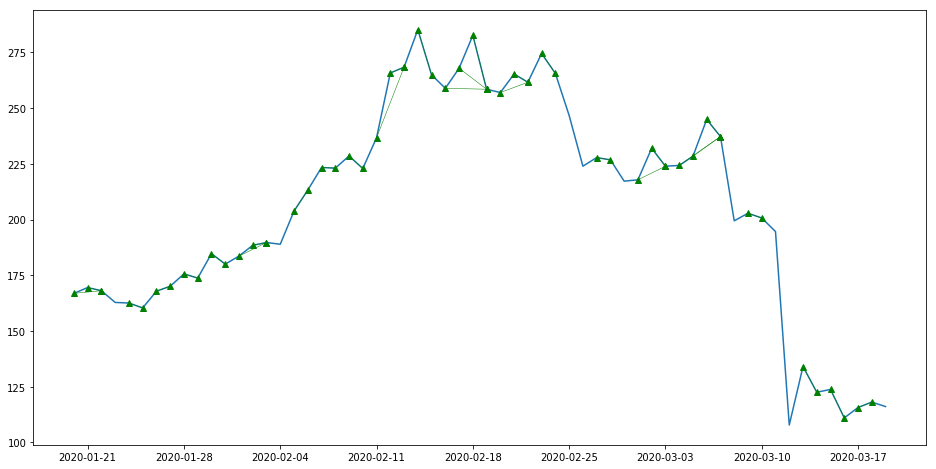

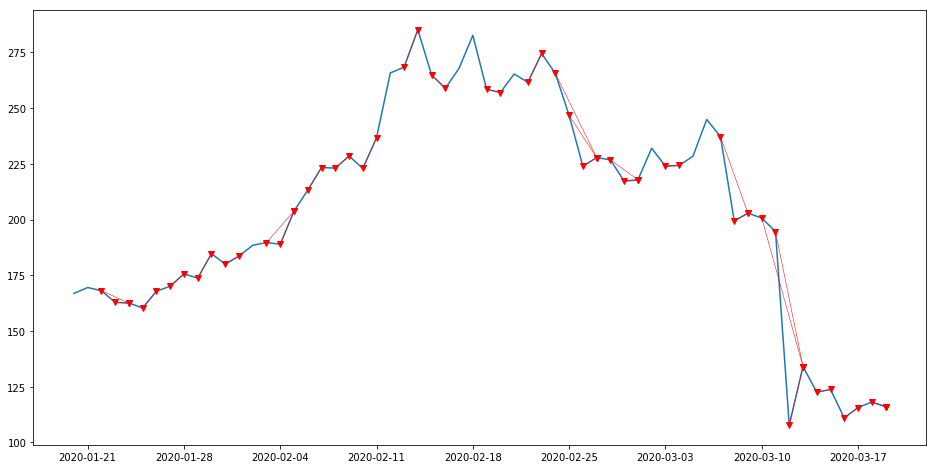

In [76]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [85]:
def tuning_obv_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(1,11,1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'z', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    data['OBV'] = ta.OBV(data.c, data.v)
    for i in range(1,11,1):
        for j in range(1,11,1):
            for z in range(1,j,1):
                # Create strategy
                data['OBV_startegy'] = 0
                data['OBV_startegy'] = np.where((data['OBV'] > data['OBV'].shift(i)) & 
                                                (data['c']/data['c'].shift(z) > data['c'].shift()/data['c'].shift(j)), 1, data['OBV_startegy'])
                data['OBV_startegy'] = np.where((data['OBV'] > data['OBV'].shift(i)) & 
                                                (data['c']/data['c'].shift(z) < data['c'].shift()/data['c'].shift(j)), -1, data['OBV_startegy'])
                data['OBV_startegy'] = np.where((data['OBV'] < data['OBV'].shift(i)) & 
                                                (data['c']/data['c'].shift(z) > data['c'].shift()/data['c'].shift(j)), 1, data['OBV_startegy'])
                data['OBV_startegy'] = np.where((data['OBV'] < data['OBV'].shift(i)) & 
                                                (data['c']/data['c'].shift(z) < data['c'].shift()/data['c'].shift(j)), -1, data['OBV_startegy'])
                t_period = 60
                # Test strategy
                orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'OBV_startegy', 
                                         time_period = t_period, tplong = lambda x: x == -1 or x == 0, tpshort = lambda x: x == 1 or x == 0)

                s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                olong = orders[orders['order']=='long'].shape[0]
                oshort = orders[orders['order']=='short'].shape[0]
                if s > 0:
                    df_params.loc[dd,:] = [s, i, j, z, olong, oshort, s*(olong+oshort)/2]
                    dd +=1
        #if (t-1)%5 == 0:
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [86]:
df_params_obv = tuning_obv_strategy(data, t_period = 90)

Progress: 10.00%
Time: 0:00:31
Left time: 0:04:40
Progress: 20.00%
Time: 0:01:01
Left time: 0:04:06
Progress: 30.00%
Time: 0:01:31
Left time: 0:03:34
Progress: 40.00%
Time: 0:02:02
Left time: 0:03:03
Progress: 50.00%
Time: 0:02:32
Left time: 0:02:32
Progress: 60.00%
Time: 0:03:03
Left time: 0:02:02
Progress: 70.00%
Time: 0:03:34
Left time: 0:01:32
Progress: 80.00%
Time: 0:04:04
Left time: 0:01:01
Progress: 90.00%
Time: 0:04:35
Left time: 0:00:30
Progress: 100.00%
Time: 0:05:04
Left time: 0:00:00


In [107]:
df_params_obv2 = df_params_obv.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_obv2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_obv2.to_csv(r'obv_strat_tuning.csv')
df_params_obv3 = df_params_obv2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_obv3[(df_params_obv3['orders_long']+5>df_params_obv3['orders_short'])&
              (df_params_obv3['orders_long']-5<df_params_obv3['orders_short'])&
              (df_params_obv3['orders_long']>5)&(df_params_obv3['orders_short']>5)].head(10)
df_params_obv3.head(10)

,maxx,i,j,z,orders_long,orders_short,alpha
0,1.21129,1,6,4,27,33,36.3386
4,1.17702,1,10,7,28,32,35.3107
3,0.846212,1,9,5,23,37,25.3863
2,0.631833,1,8,4,25,35,18.955
5,0.244213,1,10,9,27,33,7.32638
1,0.1632,1,7,6,31,29,4.89601


<a id='mom'></a>

## 6. [Momentum](#start)

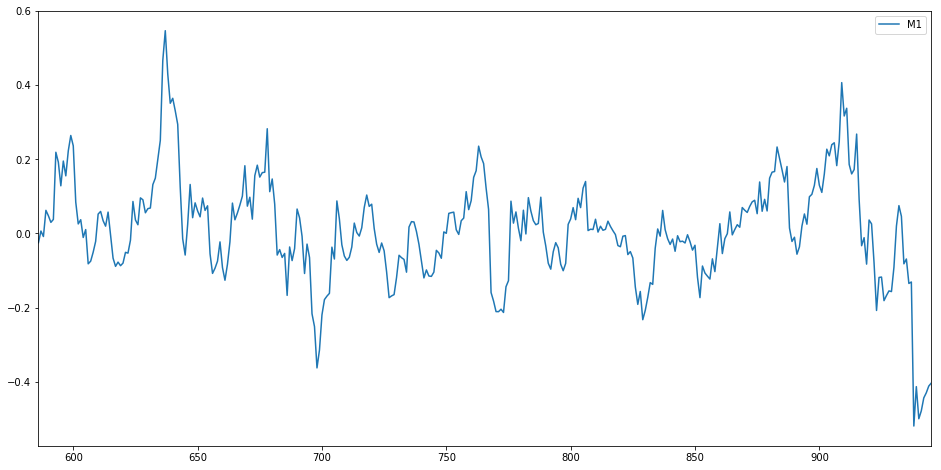

In [113]:
# Momentum
#data['M1'] = data.c.diff()
#data['M1'] = np.where(data.c.diff() > 0, 1, 0)
data['M1'] = data.c.pct_change(8)
data[['M1']].tail(360).plot(figsize=(16,8))

In [118]:
# Create strategy
data['M_startegy'] = 0
data['M_startegy'] = np.where(data.M1 > 0.1, 1, -1)
#data['M_startegy'] = np.where((data.M_startegy == 1) & (data.M_startegy.shift() == 1), 2, data['M_startegy'])
#data['M_startegy'] = np.where((data.M_startegy == -1) & (data.M_startegy.shift() == -1), 2, data['M_startegy'])
t_period = 90
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'M_startegy', 
                         time_period = t_period, 
                         tplong = lambda x: x == -1 or x == 2, 
                         tpshort = lambda x: x == 1 or x == 2,
                         close_nxt_day = False)

Paid for long 280.70000000000005
Profit from long 26.5066281537078
Perc_long = 9.44%
Paid for short 621.5499999999993
Profit from short 81.94840403402289
Perc_short = 13.18%


In [119]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2019-12-21 00:00:00,126.86301,10.025,0.078825,short,close,2020-01-10 00:00:00,144.98484,-1.39203,-13.8856,0,253.72602
1,2019-12-22 00:00:00,131.95791,10.025,0.075782,short,close,2020-01-10 00:00:00,144.98484,-0.951216,-9.48844,0,263.91582
2,2019-12-23 00:00:00,127.67220,10.025,0.078326,short,close,2020-01-10 00:00:00,144.98484,-1.31967,-13.1638,0,255.34440
3,2019-12-24 00:00:00,127.62225,10.025,0.078356,short,close,2020-01-10 00:00:00,144.98484,-1.32411,-13.208,0,255.24450
4,2019-12-25 00:00:00,124.96491,10.025,0.080022,short,close,2020-01-10 00:00:00,144.98484,-1.56544,-15.6154,0,249.92982


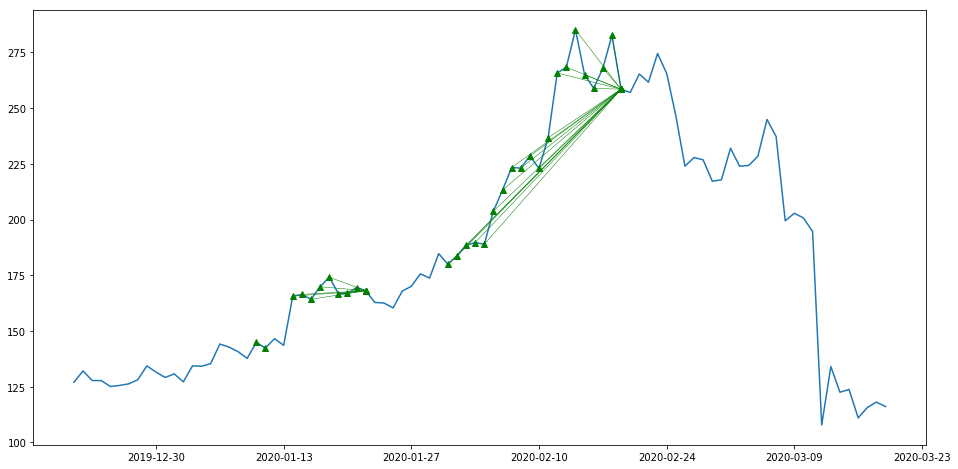

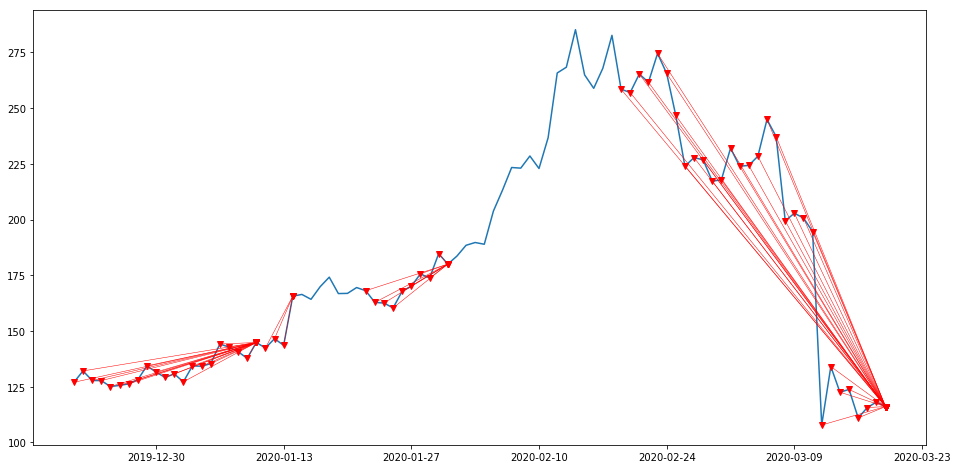

In [120]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [103]:
def tuning_moment_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(1,10,1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in range(1,10,1):
        for j in np.arange(0.0,0.15,0.01):
            data['M1'] = data.c.pct_change(i)
            # Create strategy
            data['M_startegy'] = 0
            data['M_startegy'] = np.where(data.M1 > j, 1, -1)
            # Test strategy
            orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'M_startegy', 
                                     time_period = t_period, 
                                     tplong = lambda x: x == -1 or x == 2, 
                                     tpshort = lambda x: x == 1 or x == 2,
                                     close_nxt_day = False)

            s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
            olong = orders[orders['order']=='long'].shape[0]
            oshort = orders[orders['order']=='short'].shape[0]
            if s > 0 or s < 0:
                df_params.loc[dd,:] = [s, i, j, olong, oshort, s*(olong+oshort)/2]
                dd +=1
        #if (t-1)%2 == 0:
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [104]:
df_params_moment = tuning_moment_strategy(data, t_period = 90)

Progress: 11.11%
Time: 0:00:15
Left time: 0:02:03
Progress: 22.22%
Time: 0:00:30
Left time: 0:01:45
Progress: 33.33%
Time: 0:00:45
Left time: 0:01:30
Progress: 44.44%
Time: 0:01:00
Left time: 0:01:15
Progress: 55.56%
Time: 0:01:14
Left time: 0:00:59
Progress: 66.67%
Time: 0:01:29
Left time: 0:00:44
Progress: 77.78%
Time: 0:01:44
Left time: 0:00:29
Progress: 88.89%
Time: 0:02:00
Left time: 0:00:15
Progress: 100.00%
Time: 0:02:16
Left time: 0:00:00


In [108]:
df_params_moment2 = df_params_moment.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_moment2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_moment2.to_csv(r'moment_strat_tuning.csv')
df_params_moment3 = df_params_moment2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_moment3[(df_params_moment3['orders_long']+5>df_params_moment3['orders_short'])&
              (df_params_moment3['orders_long']-5<df_params_moment3['orders_short'])&
              (df_params_moment3['orders_long']>5)&(df_params_moment3['orders_short']>5)].head(10)
df_params_moment3.head(10)

,maxx,i,j,orders_long,orders_short,alpha
115,11.3138,8,0.1,28,62,509.12
113,11.2055,8,0.08,33,57,504.247
114,11.0922,8,0.09,31,59,499.149
116,10.4245,8,0.11,27,63,469.102
131,9.57556,9,0.11,30,60,430.9
130,9.53738,9,0.1,31,59,429.182
132,8.86266,9,0.12,29,61,398.82
100,7.66447,7,0.1,27,63,344.901
117,7.59855,8,0.12,26,64,341.935
88,7.49302,6,0.13,19,71,337.186


<a id='mfi'></a>

## 8. [Money Flow Index](#start)

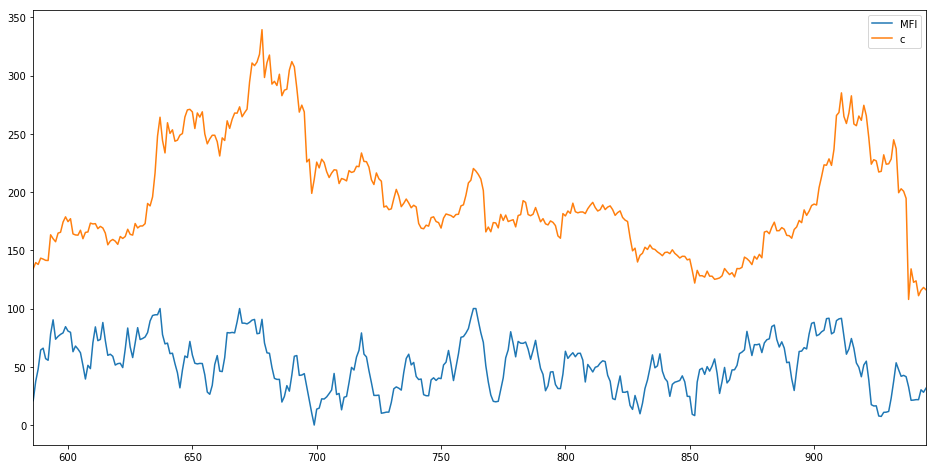

In [11]:
def mfi(df, n):
    '''
    Creates a Money Flow Indicator base on High, Low, Close and Volume values
    '''

    tp = (df.h + df.l + df.c) / 3.0

    # 2 up or down column
    up_down = np.where(tp > tp.shift(1), 1, np.where(tp < tp.shift(1), -1, 0))

    # 3 money flow
    mf = tp * df.v * up_down

    # 4 positive and negative money flow with n periods
    n_positive_mf = mf.rolling(n).apply(lambda x: np.sum(np.where(x >= 0.0, x, 0.0)), raw=True)
    n_negative_mf = abs(mf.rolling(n).apply(lambda x: np.sum(np.where(x < 0.0, x, 0.0)), raw=True))

    # 5 money flow index
    mr = n_positive_mf / n_negative_mf
    mfin = (100 - (100 / (1 + mr)))
    
    return mfin

# Money Flow Index
data['MFI'] = mfi(data[['h','l','c','v']], 8)
data[['MFI','c']].tail(360).plot(figsize=(16,8))

In [18]:
# Create strategy
data['MFI_startegy'] = 0
data['MFI_startegy'] = np.where((data['MFI'] > 100-31) & (data['MFI'].shift() < 100-31), 1, data['MFI_startegy'])
data['MFI_startegy'] = np.where((data['MFI'] < 31) & (data['MFI'].shift() > 31), -1, data['MFI_startegy'])
data['MFI_startegy'] = np.where((data['MFI'] > 31+18) & (data['MFI'] < 100-31-18), 2, data['MFI_startegy'])

t_period = 60
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'MFI_startegy', 
                         time_period = t_period, tplong = lambda x: x == 2, tpshort = lambda x: x == 2)

Paid for long 30.074999999999996
Profit from long 9.292462041960388
Perc_long = 30.90%
Paid for short 30.074999999999996
Profit from short 0.3973445548524088
Perc_short = 1.32%


In [19]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-01-21 00:00:00,169.65949,10.025,0.058942,long,close,2020-02-21 00:00:00,265.00473,5.57918,55.6527,0,0.00000
1,2020-01-26 00:00:00,167.69214,10.025,0.059633,short,close,2020-02-21 00:00:00,265.53527,-5.79385,-57.794,0,335.38428
2,2020-02-01 00:00:00,183.78360,10.025,0.054412,long,close,2020-02-21 00:00:00,265.00473,4.37997,43.6905,0,0.00000
3,2020-02-18 00:00:00,282.89261,10.025,0.035349,long,close,2020-02-21 00:00:00,265.00473,-0.666688,-6.65026,0,0.00000
4,2020-02-26 00:00:00,223.70607,10.025,0.044702,short,close,2020-03-19 00:00:00,116.21610,4.83516,48.231,0,447.41214


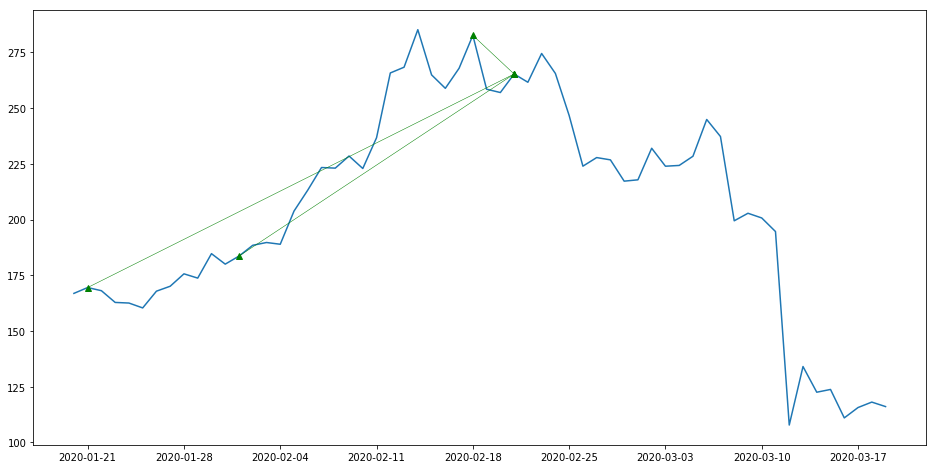

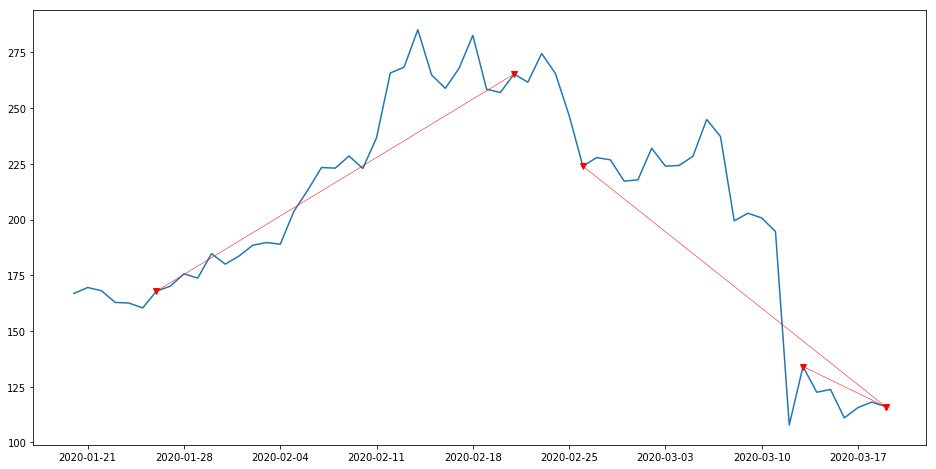

In [20]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

In [30]:
def tuning_mfi_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(5,40,1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'q', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in range(5,40,1):
        for j in range(20,40,1):
            for q in range(1,20,1):
                data['MFI'] = mfi(data[['h','l','c','v']], i)
                # Create strategy
                data['MFI_startegy'] = 0
                data['MFI_startegy'] = np.where((data['MFI'] > 100-j) & (data['MFI'].shift() < 100-j), 1, data['MFI_startegy'])
                data['MFI_startegy'] = np.where((data['MFI'] < j) & (data['MFI'].shift() > j), -1, data['MFI_startegy'])
                data['MFI_startegy'] = np.where((data['MFI'] > j+q) & (data['MFI'] < 100-j-q), 2, data['MFI_startegy'])
                # Test strategy
                orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'MFI_startegy', 
                                         time_period = t_period, tplong = lambda x: x == 2, tpshort = lambda x: x == 2)

                s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                olong = orders[orders['order']=='long'].shape[0]
                oshort = orders[orders['order']=='short'].shape[0]
                if s > 0 or s < 0:
                    df_params.loc[dd,:] = [s, i, j, q, olong, oshort, s*(olong+oshort)/2]
                    dd +=1
        #if (t-1)%5 == 0:
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [31]:
df_params_mfi = tuning_mfi_strategy(data, t_period = 180)

Progress: 2.86%
Time: 0:11:26
Left time: 6:29:16
Progress: 5.71%
Time: 0:21:28
Left time: 5:54:20
Progress: 8.57%
Time: 0:30:14
Left time: 5:22:38
Progress: 11.43%
Time: 0:34:25
Left time: 4:26:49
Progress: 14.29%
Time: 0:36:42
Left time: 3:40:16
Progress: 17.14%
Time: 0:38:50
Left time: 3:07:45
Progress: 20.00%
Time: 0:40:53
Left time: 2:43:33
Progress: 22.86%
Time: 0:42:45
Left time: 2:24:19
Progress: 25.71%
Time: 0:44:44
Left time: 2:09:14
Progress: 28.57%
Time: 0:46:41
Left time: 1:56:44
Progress: 31.43%
Time: 0:48:29
Left time: 1:45:48
Progress: 34.29%
Time: 0:50:09
Left time: 1:36:08
Progress: 37.14%
Time: 0:51:52
Left time: 1:27:46
Progress: 40.00%
Time: 0:53:32
Left time: 1:20:18
Progress: 42.86%
Time: 0:55:11
Left time: 1:13:35
Progress: 45.71%
Time: 0:56:45
Left time: 1:07:24
Progress: 48.57%
Time: 0:58:14
Left time: 1:01:39
Progress: 51.43%
Time: 0:59:38
Left time: 0:56:19
Progress: 54.29%
Time: 1:01:06
Left time: 0:51:27
Progress: 57.14%
Time: 1:02:31
Left time: 0:46:53
Pro

In [32]:
df_params_mfi2 = df_params_mfi.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_mfi2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_mfi2.to_csv(r'mfi_strat_tuning.csv')
df_params_mfi3 = df_params_mfi2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_mfi3[(df_params_mfi3['orders_long']+5>df_params_mfi3['orders_short'])&
              (df_params_mfi3['orders_long']-5<df_params_mfi3['orders_short'])&
              (df_params_mfi3['orders_long']>5)&(df_params_mfi3['orders_short']>5)].head(10)
df_params_mfi3.head(10)

,maxx,i,j,q,orders_long,orders_short,alpha
1366,21.8137,8,31,18,10,10,218.137
1365,21.2589,8,31,17,10,10,212.589
4164,29.208,15,39,4,5,9,204.456
4146,29.1756,15,38,5,5,9,204.229
4489,28.4366,16,36,6,7,7,199.057
4128,30.5388,15,37,6,6,7,198.502
4110,30.1262,15,36,7,6,7,195.82
1384,18.8253,8,32,17,9,11,188.253
750,12.6729,6,39,10,14,15,183.757
1383,18.1443,8,32,16,9,11,181.443


<a id='reg'></a>

## 9. [Regimes](#start)

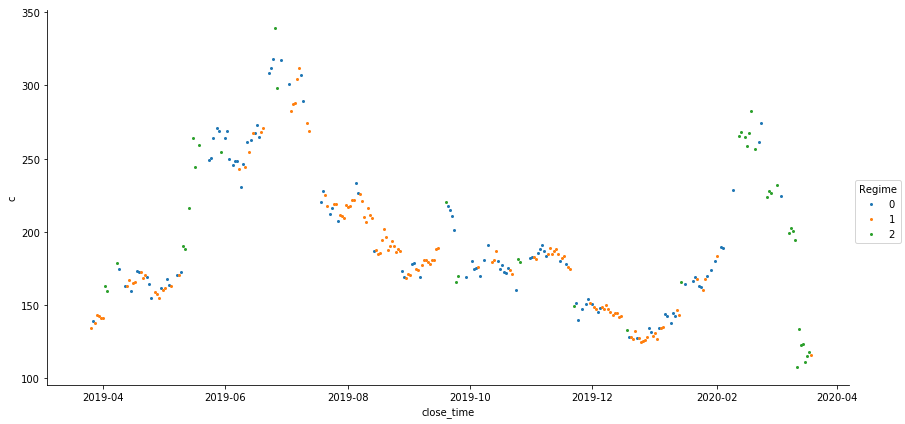

,close_time,o,h,l,c,v,Return4,Regime,Regime_startegy
0,2017-08-17,301.13,312.18,298.00,302.00,7.030710e+03,NaN,NaN,0
1,2017-08-18,302.00,311.79,283.94,293.96,9.537846e+03,-0.026983,NaN,0
2,2017-08-19,293.31,299.90,278.00,290.91,2.146198e+03,-0.010430,NaN,0
3,2017-08-20,289.41,300.53,282.85,299.10,2.510139e+03,0.027764,NaN,0
4,2017-08-21,299.10,346.52,294.60,323.29,5.219445e+03,0.077772,NaN,0
...,...,...,...,...,...,...,...,...,...
941,2020-03-15,122.54,133.50,120.16,123.78,1.312951e+06,0.010068,2.0,0
942,2020-03-16,123.82,124.33,101.10,111.02,2.442064e+06,-0.108795,2.0,-1
943,2020-03-17,111.02,120.80,109.38,115.67,1.295108e+06,0.041031,2.0,-1
944,2020-03-18,115.67,118.50,109.86,118.11,1.201850e+06,0.020875,2.0,0


In [126]:
from sklearn import mixture as mix
def regimes(data, ret_i, comps):
    data['Return4'] = np.log(data['c']/data['c'].shift(ret_i))
    data = data.dropna()
    df = data.tail(360).drop(columns = ['close_time']).copy()
    #df = df[['MFI_startegy', 'c', 'M_startegy', 'OBV_startegy', 'RSI_startegy', 'MACD_startegy', 'BB_startegy', 'SMA_startegy']].copy()
    df = df[['o','h','l','c','v', 'Return4']].copy()
    #df['Return4'] = np.log(df['c']/df['c'].shift(4))
    #df = df.dropna()
    unsup = mix.GaussianMixture(n_components=comps, 
                                covariance_type="spherical", 
                                n_init=100, 
                                random_state=42)

    unsup.fit(np.reshape(df,(-1,df.shape[1])))
    regime = unsup.predict(np.reshape(df,(-1,df.shape[1])))

    Regimes = pd.DataFrame(regime,columns=['Regime'],index=df.index)\
                           .join(df, how='inner')\
                                  .assign(market_cu_return=df.c.diff().cumsum())\
                                         .reset_index(drop=False)\
                                                     .rename(columns={'index':'Date'})
    return Regimes.set_index('Date')
data['Regime'] = 0
#data['Regime'].iloc[-359:] = regimes(data, ret_i = 4, comps = 3)['Regime']
data.loc[-359:, 'Regime'] = regimes(data, ret_i = 1, comps = 4)['Regime']
df = data.tail(360)
order=[0,1,2]
fig = sns.FacetGrid(data=df,hue='Regime',hue_order=order,aspect=2,size= 6)
fig.map(plt.scatter,'close_time','c', s=4).add_legend()
plt.show()
data

In [130]:
# Create strategy  
data['Regime_startegy'] = 0
data['Regime_startegy'] = np.where((data['Regime'] != data['Regime'].shift()) & (data['c'].diff(12) > 0), 
                                   1,
                                   data['Regime_startegy'])
data['Regime_startegy'] = np.where((data['Regime'] != data['Regime'].shift()) & (data['c'].diff(12) < 0), 
                                   -1,
                                   data['Regime_startegy'])
t_period = 30
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'Regime_startegy', 
                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

Paid for long 40.099999999999994
Profit from long 0.5449767787996329
Perc_long = 1.36%
Paid for short 90.225
Profit from short 38.99923243383651
Perc_short = 43.22%


In [131]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2020-02-19 00:00:00,258.70845,10.025,0.038654,long,close,2020-02-24 00:00:00,265.25448,0.217774,2.17231,0,0.00000
1,2020-02-20 00:00:00,257.21696,10.025,0.038878,long,close,2020-02-24 00:00:00,265.25448,0.277168,2.76477,0,0.00000
2,2020-02-21 00:00:00,265.53527,10.025,0.037660,long,close,2020-02-24 00:00:00,265.25448,-0.0455639,-0.454503,0,0.00000
3,2020-02-22 00:00:00,261.83157,10.025,0.038192,long,close,2020-02-24 00:00:00,265.25448,0.0955987,0.953603,0,0.00000
4,2020-02-24 00:00:00,265.25448,10.025,0.037700,short,close,2020-03-19 00:00:00,116.21610,5.64808,56.3399,0,530.50896


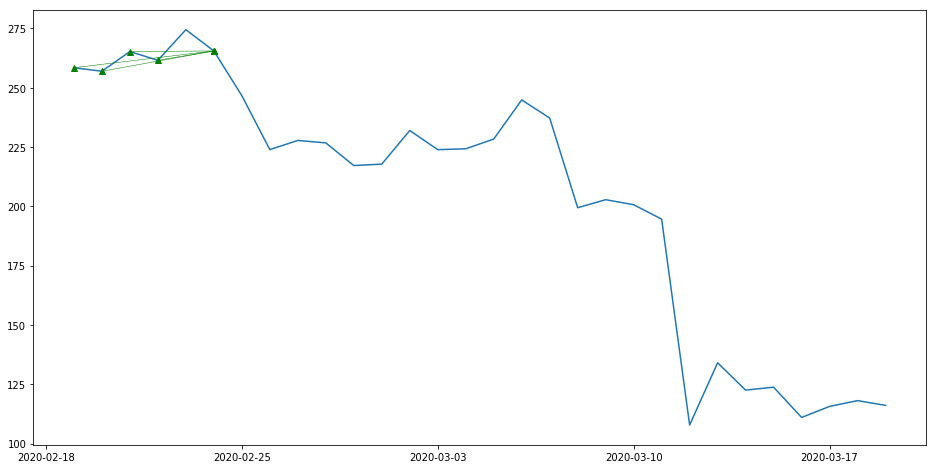

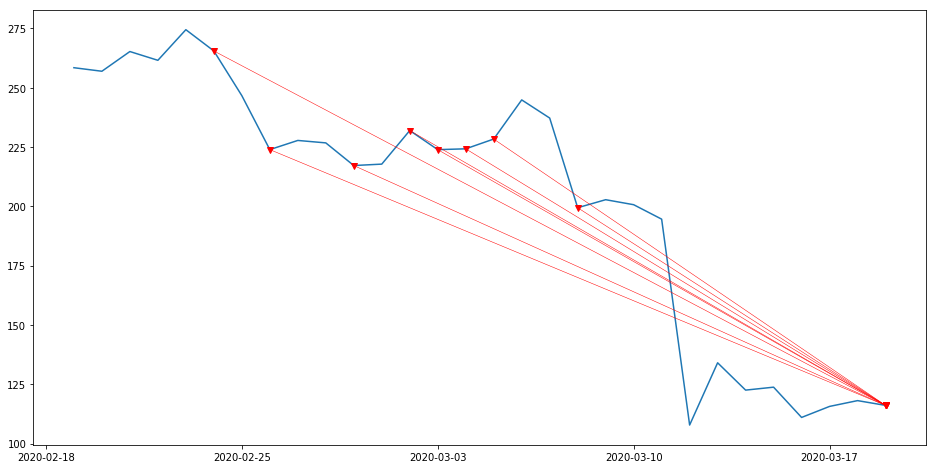

In [132]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

In [123]:
def tuning_reg_strategy(data, t_period = 30):  
    maxx = 0
    ll = len(range(1,15,1))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'q', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in range(1,15,1):
        for j in range(2,6,1):
            data['Regime'] = 0
            data.loc[-359:, 'Regime'] = regimes(data, ret_i = i, comps = j)['Regime']
            for q in range(1,15,1):
                # Create strategy  
                data['Regime_startegy'] = 0
                data['Regime_startegy'] = np.where((data['Regime'] != data['Regime'].shift()) & (data['c'].diff(q) > 0), 
                                                   1,
                                                   data['Regime_startegy'])
                data['Regime_startegy'] = np.where((data['Regime'] != data['Regime'].shift()) & (data['c'].diff(q) < 0), 
                                                   -1,
                                                   data['Regime_startegy'])
                t_period = 60
                # Test strategy
                orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'Regime_startegy', 
                                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)

                s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                olong = orders[orders['order']=='long'].shape[0]
                oshort = orders[orders['order']=='short'].shape[0]
                if s > 0 or s < 0:
                    df_params.loc[dd,:] = [s, i, j, q, olong, oshort, s*(olong+oshort)/2]
                    dd +=1
        #if (t-1)%5 == 0:
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        t += 1
    return df_params

In [124]:
df_params_reg = tuning_reg_strategy(data, t_period = 180)

Progress: 7.14%
Time: 0:01:20
Left time: 0:17:28
Progress: 14.29%
Time: 0:02:44
Left time: 0:16:25
Progress: 21.43%
Time: 0:04:06
Left time: 0:15:05
Progress: 28.57%
Time: 0:05:30
Left time: 0:13:45
Progress: 35.71%
Time: 0:06:53
Left time: 0:12:23
Progress: 42.86%
Time: 0:08:16
Left time: 0:11:01
Progress: 50.00%
Time: 0:09:37
Left time: 0:09:37
Progress: 57.14%
Time: 0:10:58
Left time: 0:08:13
Progress: 64.29%
Time: 0:12:20
Left time: 0:06:51
Progress: 71.43%
Time: 0:13:45
Left time: 0:05:30
Progress: 78.57%
Time: 0:15:01
Left time: 0:04:05
Progress: 85.71%
Time: 0:15:49
Left time: 0:02:38
Progress: 92.86%
Time: 0:17:11
Left time: 0:01:19
Progress: 100.00%
Time: 0:18:32
Left time: 0:00:00


In [125]:
df_params_reg2 = df_params_reg.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_reg2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_reg2.to_csv(r'reg_strat_tuning.csv')
df_params_reg3 = df_params_reg2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_reg3[(df_params_reg3['orders_long']+5>df_params_reg3['orders_short'])&
              (df_params_reg3['orders_long']-5<df_params_reg3['orders_short'])&
              (df_params_reg3['orders_long']>5)&(df_params_reg3['orders_short']>5)].head(10)
df_params_reg3.head(10)

,maxx,i,j,q,orders_long,orders_short,alpha
53,31.0421,1,5,12,22,15,574.278
39,36.9173,1,4,12,22,9,572.218
51,25.0231,1,5,10,20,17,462.927
54,24.8885,1,5,13,23,14,460.438
37,29.6187,1,4,10,20,11,459.09
40,25.2972,1,4,13,23,8,392.106
50,20.3595,1,5,9,18,19,376.65
22,28.6535,1,3,9,15,11,372.495
52,20.0789,1,5,11,20,17,371.459
25,28.3196,1,3,12,20,6,368.154


<a id='gt'></a>

## 10. [Google Trend](#start)

c:\python\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


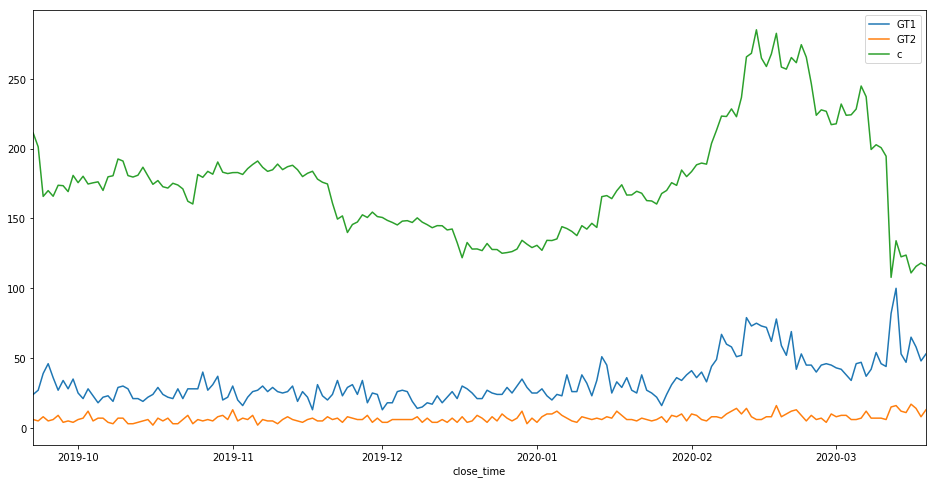

In [9]:
from pytrends.request import TrendReq
pytrend = TrendReq()
#begin_date = datetime.strptime("7/1/2019", '%m/%d/%Y').date()
#end_date = datetime.strptime("12/1/2019", '%m/%d/%Y').date()
#data.reset_index(inplace = True)
begin_date = data['close_time'].iloc[-180]
end_date = data['close_time'].iloc[-1]
user_timeframe = begin_date.strftime('%Y-%m-%d') + ' ' + end_date.strftime('%Y-%m-%d')
user_kw_list = ['ETH USD', 'Buy Ethereum']

'''pytrend.get_historical_interest(user_kw_list, 
                                year_start=begin_date.year, 
                                month_start=begin_date.month, 
                                day_start=begin_date.day, 
                                #hour_start=0, 
                                year_end=end_date.year,
                                month_end=end_date.month, 
                                day_end=end_date.day,
                                #hour_end=0, 
                                cat=0,
                                geo='',
                                gprop='',
                                sleep=0)'''
pytrend.build_payload(kw_list=user_kw_list, timeframe=user_timeframe, geo='')
interest_over_time_df = pytrend.interest_over_time().drop(columns = "isPartial")#.reset_index(drop=True)
data.set_index('close_time', inplace= True)
data['GT1'] = 0
data['GT2'] = 0
data['GT1'].loc[begin_date:] = interest_over_time_df['ETH USD']
data['GT2'].loc[begin_date:] = interest_over_time_df['Buy Ethereum']
last_date = interest_over_time_df.index[-1] + timedelta(days = 1)
data[['GT1','GT2', 'c']].tail(180).plot(figsize=(16,8))
data['GT1'].loc[last_date:] = 0
data['GT2'].loc[last_date:] = 0
data.reset_index(inplace = True)

In [13]:
# Create strategy
data['GT_startegy'] = 0
data['GT_startegy'] = np.where((data['GT2']/data['GT1'] > 0.3) & (data['c'].pct_change() > 0.015), 1, data['GT_startegy'])
data['GT_startegy'] = np.where((data['GT2']/data['GT1'] < 0.15) & (data['c'].pct_change() < -0.045), -1, data['GT_startegy'])
t_period = 180
# Test strategy
orders, ord_res = tester(data, 0, 0, verb = 1, strategy = 'GT_startegy',
                         time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1)  

Paid for long 100.25
Profit from long 55.742907138630116
Perc_long = 55.60%
Paid for short 30.074999999999996
Profit from short 10.739942165304086
Perc_short = 35.71%


In [14]:
orders.head()

,time,price,paid,size,order,type,close_time,close_price,profit,perc,TP,SL
0,2019-09-27 00:00:00,173.96379,10.025,0.057483,long,close,2019-10-11 00:00:00,180.53928,0.342602,3.41748,0,0.00000
1,2019-10-02 00:00:00,180.42024,10.025,0.055426,long,close,2019-10-11 00:00:00,180.53928,-0.0284087,-0.283378,0,0.00000
2,2019-10-11 00:00:00,180.53928,10.025,0.055390,short,close,2019-11-05 00:00:00,188.86868,-0.425901,-4.24839,0,361.07856
3,2019-11-05 00:00:00,188.86868,10.025,0.052947,long,close,2020-02-15 00:00:00,264.61512,3.97152,39.6162,0,0.00000
4,2019-12-08 00:00:00,150.59044,10.025,0.066405,long,close,2020-02-15 00:00:00,264.61512,7.52927,75.1049,0,0.00000


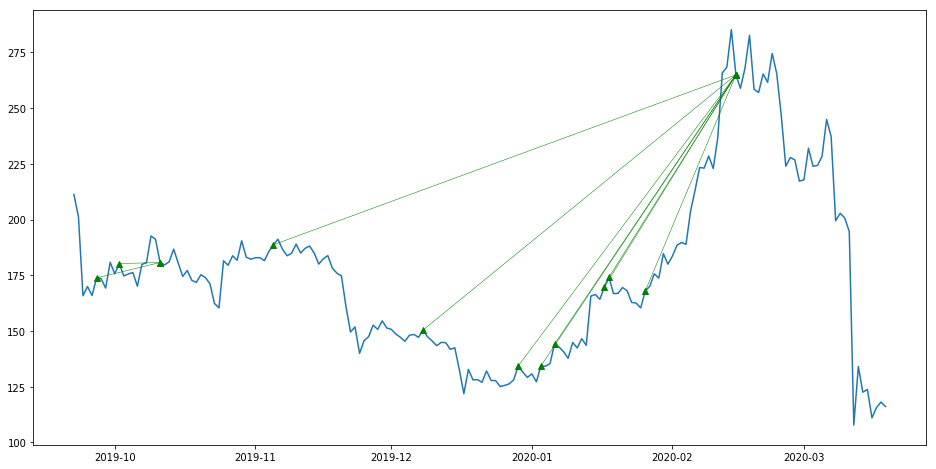

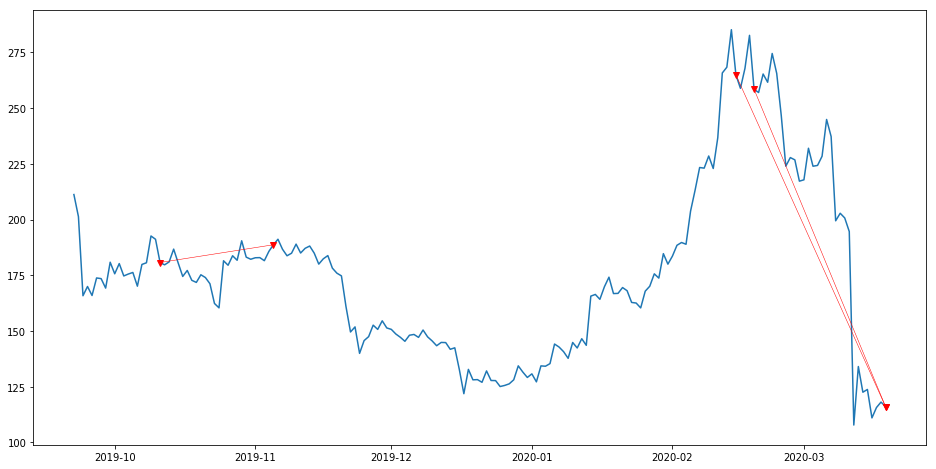

In [15]:
# PLot orders
plot_orders(orders, data.tail(t_period).copy(), 'long')
plot_orders(orders, data.tail(t_period).copy(), 'short')

## Tuning

In [94]:
def tuning_gt_strategy(data, t_period = 30):    
    maxx = 0
    ll = len(np.arange(0.05,0.6,0.05)) #* len(np.arange(0.0,0.6,0.05))
    ti = time.time()
    t=1
    df_params = pd.DataFrame(columns = ['maxx', 'i', 'j', 'z1', 'z2', 'orders_long', 'orders_short', 'alpha'])
    dd = 0
    for i in np.arange(0.05,0.6,0.05):
        for j in np.arange(0.05,0.6,0.05):
            for z1 in np.arange(0.005,0.05,0.005):
                for z2 in np.arange(0.005,0.05,0.005):
                    # Create strategy
                    data['GT_startegy'] = 0
                    data['GT_startegy'] = np.where((data['GT2']/data['GT1'] > i) & (data['c'].pct_change() > z1), 1, data['GT_startegy'])
                    data['GT_startegy'] = np.where((data['GT2']/data['GT1'] < j) & (data['c'].pct_change() < -z2), -1, data['GT_startegy'])
                    # Test strategy
                    orders, ord_res = tester(data, 0, 0, verb = 0, strategy = 'GT_startegy',
                                             time_period = t_period, tplong = lambda x: x == -1, tpshort = lambda x: x == 1) 
                    s = 100 * ((ord_res[1]/(ord_res[0]+0.00001)) + (ord_res[3]/(ord_res[2]+0.00001)))/2
                    olong = orders[orders['order']=='long'].shape[0]
                    oshort = orders[orders['order']=='short'].shape[0]
                    if s > 0:
                        df_params.loc[dd,:] = [s, i, j, z1, z2, olong, oshort, s*(olong+oshort)/2]
                        dd +=1
        progress_display(t, ll, ti)
        df_params.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
        #print(df_params.sort_values(axis = 0, by = ['alpha'], ascending=False).head())
        t += 1
    return df_params

In [95]:
df_params_gt = tuning_gt_strategy(data, t_period = 180)

Progress: 9.09%
Time: 0:14:20
Left time: 2:23:24
       maxx     i     j     z1     z2 orders_long orders_short    alpha
42  34.9317  0.05  0.15  0.005  0.045          71            6  1344.87
45  32.5917  0.05  0.15   0.01  0.045          63            6  1124.41
51  28.5302  0.05  0.15  0.015  0.045          54            6  855.905
57  30.2065  0.05  0.15   0.02  0.045          45            6  770.266
3   19.2647  0.05   0.1  0.005   0.03          71            1  693.529
Progress: 18.18%
Time: 0:28:39
Left time: 2:08:56
        maxx     i     j     z1     z2 orders_long orders_short    alpha
42   34.9317  0.05  0.15  0.005  0.045          71            6  1344.87
640  35.6757   0.1  0.15  0.005  0.045          65            6  1266.49
45   32.5917  0.05  0.15   0.01  0.045          63            6  1124.41
643  32.6883   0.1  0.15   0.01  0.045          59            6  1062.37
51   28.5302  0.05  0.15  0.015  0.045          54            6  855.905
Progress: 27.27%
Time: 0:40:59


In [116]:
df_params_gt2 = df_params_gt.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_gt2.drop_duplicates(subset ="alpha", keep = 'first', inplace = True) 
df_params_gt2.to_csv(r'earf.csv')
df_params_gt3 = df_params_gt2.sort_values(axis = 0, by = ['alpha'], ascending=False)
df_params_gt3[(df_params_gt3['orders_long']+5>df_params_gt3['orders_short'])&
              (df_params_gt3['orders_long']-5<df_params_gt3['orders_short'])&
              (df_params_gt3['orders_long']>5)&(df_params_gt3['orders_short']>5)].head(10)

,maxx,i,j,z1,z2,orders_long,orders_short,alpha
3345,85.3193,0.3,0.15,0.015,0.045,9,6,639.895
3354,85.2042,0.3,0.15,0.02,0.045,8,6,596.43
3489,38.3283,0.3,0.25,0.005,0.045,16,14,574.924
3570,34.7599,0.3,0.3,0.005,0.045,16,16,556.159
3651,33.6879,0.3,0.35,0.005,0.045,16,17,555.85
4137,89.9619,0.35,0.15,0.005,0.045,6,6,539.772
3498,39.2504,0.3,0.25,0.01,0.045,12,14,510.255
3579,35.3029,0.3,0.3,0.01,0.045,12,16,494.241
3405,26.8245,0.3,0.2,0.005,0.03,16,20,482.841
3426,47.118,0.3,0.2,0.015,0.045,9,11,471.18
